# Применение методов машинного обучения к задаче определения дислексии по данным eye-tracking

In [1]:
!pip install catboost
!pip install torch_geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 2.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, re, random
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedGroupKFold
from tqdm import tqdm
from sklearn.metrics import recall_score, precision_recall_curve as PRC, accuracy_score, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    precision_score, recall_score, classification_report,
    confusion_matrix
)
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader, Subset, Sampler
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv, BatchNorm, global_mean_pool, global_max_pool
from torch_geometric.utils import add_self_loops
from torch_geometric.nn import GINEConv, global_mean_pool

In [4]:
def set_seed(seed=239):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(239)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## EDA

Выгружаем данные

In [3]:
dyslexia_socdem = pd.read_excel('/content/demo_groups.xlsx', sheet_name='dyslexia')
dyslexia_socdem.head()

,Group,SubjID,Sex,Grade,Age,IQ
0,dyslexia,ake05,f,3,9,35
1,dyslexia,asd17,m,4,10,34
2,dyslexia,bai24,m,1,7,28
3,dyslexia,eki26,f,1,8,35
4,dyslexia,fka11,m,2,9,32


In [31]:
norm_socdem = pd.read_excel('/content/demo_groups.xlsx', sheet_name='norm')
norm_socdem['Sex'] = norm_socdem['Sex'].apply(lambda x: 'f' if x == 'fem' else 'm')
norm_socdem.head()

,Group,SubjID,Sex,Grade,Age,IQ
0,norm,10,f,4,10,23
1,norm,108,f,4,10,34
2,norm,11_norm1,f,2,9,28
3,norm,11,m,4,10,34
4,norm,12_norm1,m,2,8,32


In [7]:
risk_socdem = pd.read_excel('/content/demo_groups.xlsx', sheet_name='risk')
risk_socdem.head()

,Group,SubjID,Sex,Grade,Age,IQ
0,risk,s10,m,1,7,29
1,risk,s17,f,1,7,21
2,risk,s25,f,1,7,30
3,risk,s29,m,1,6,27
4,risk,s58,f,1,8,32


Посмотрим на распределения признаков между группами

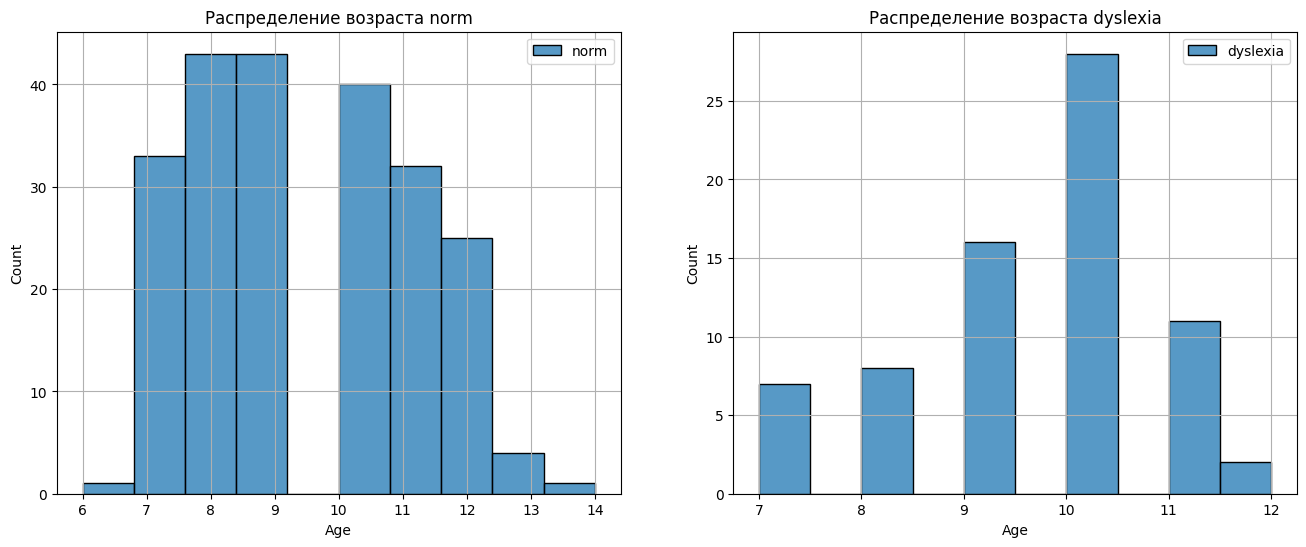

In [8]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.histplot(norm_socdem['Age'], bins=10, label = "norm")
plt.grid()
plt.legend()
plt.title("Распределение возраста norm")
plt.subplot(1, 2, 2)
sns.histplot(dyslexia_socdem['Age'], bins=10, label="dyslexia")
plt.grid()
plt.legend()
plt.title("Распределение возраста dyslexia")
plt.show();

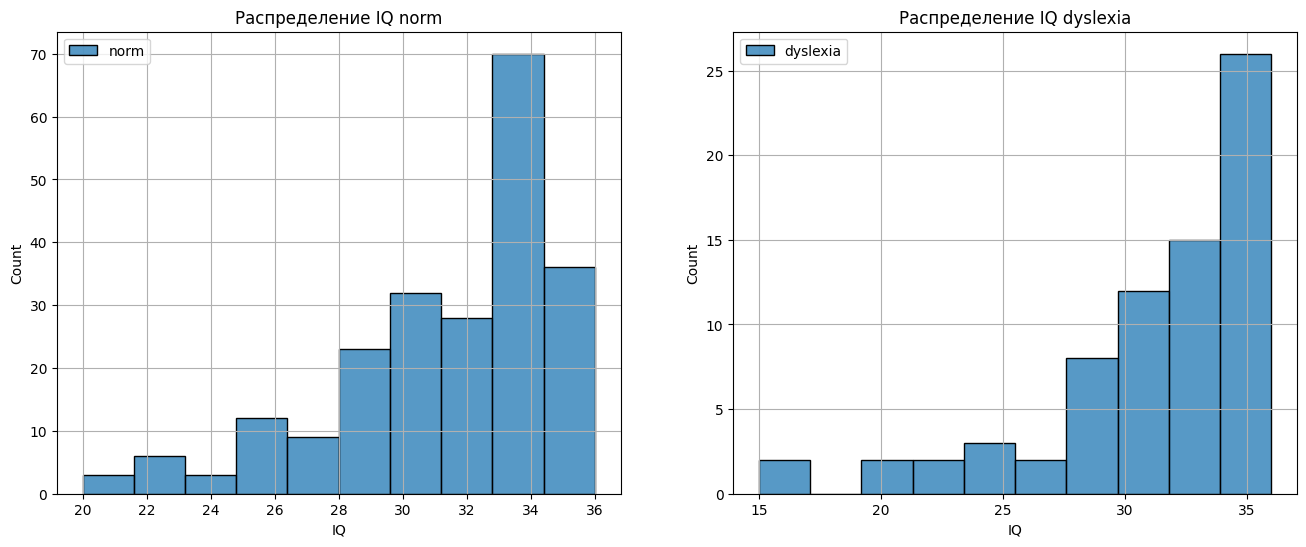

In [9]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.histplot(norm_socdem['IQ'], bins=10, label = "norm")
plt.grid()
plt.legend()
plt.title("Распределение IQ norm")
plt.subplot(1, 2, 2)
sns.histplot(dyslexia_socdem['IQ'], bins=10, label="dyslexia")
plt.grid()
plt.legend()
plt.title("Распределение IQ dyslexia")
plt.show();

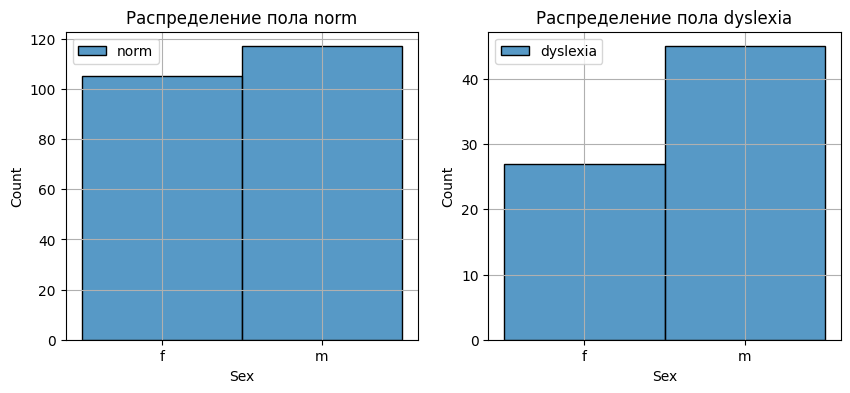

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(norm_socdem['Sex'], bins=10, label = "norm")
plt.grid()
plt.legend()
plt.title("Распределение пола norm")
plt.subplot(1, 2, 2)
sns.histplot(dyslexia_socdem['Sex'], bins=10, label="dyslexia")
plt.grid()
plt.legend()
plt.title("Распределение пола dyslexia")
plt.show();

In [4]:
fixations = pd.read_excel('/content/Fixation_report_dyslexia.xlsx', sheet_name='data')
fixations.head()

,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION
0,m90,26,1,169.6,503.0,613
1,m90,26,2,233.5,522.0,130
2,m90,26,1,163.8,517.1,312
3,m90,26,2,205.5,514.7,269
4,m90,26,2,240.2,517.5,413


In [5]:
sentences = pd.read_excel('/content/Fixation_report_dyslexia.xlsx', sheet_name='Предложения')
sentences.head()

,number,sentence
0,4,"У них был уютный, спокойный дом, крепкая семья."
1,5,"Дорога вела в глухой лес, петляя по склонам."
2,6,"Мне было лень идти сметать снег, лежавший на м..."
3,7,"На кустах, росших по берегам реки, появились л..."
4,8,"Обещают, что в этом году лето будет жарким."


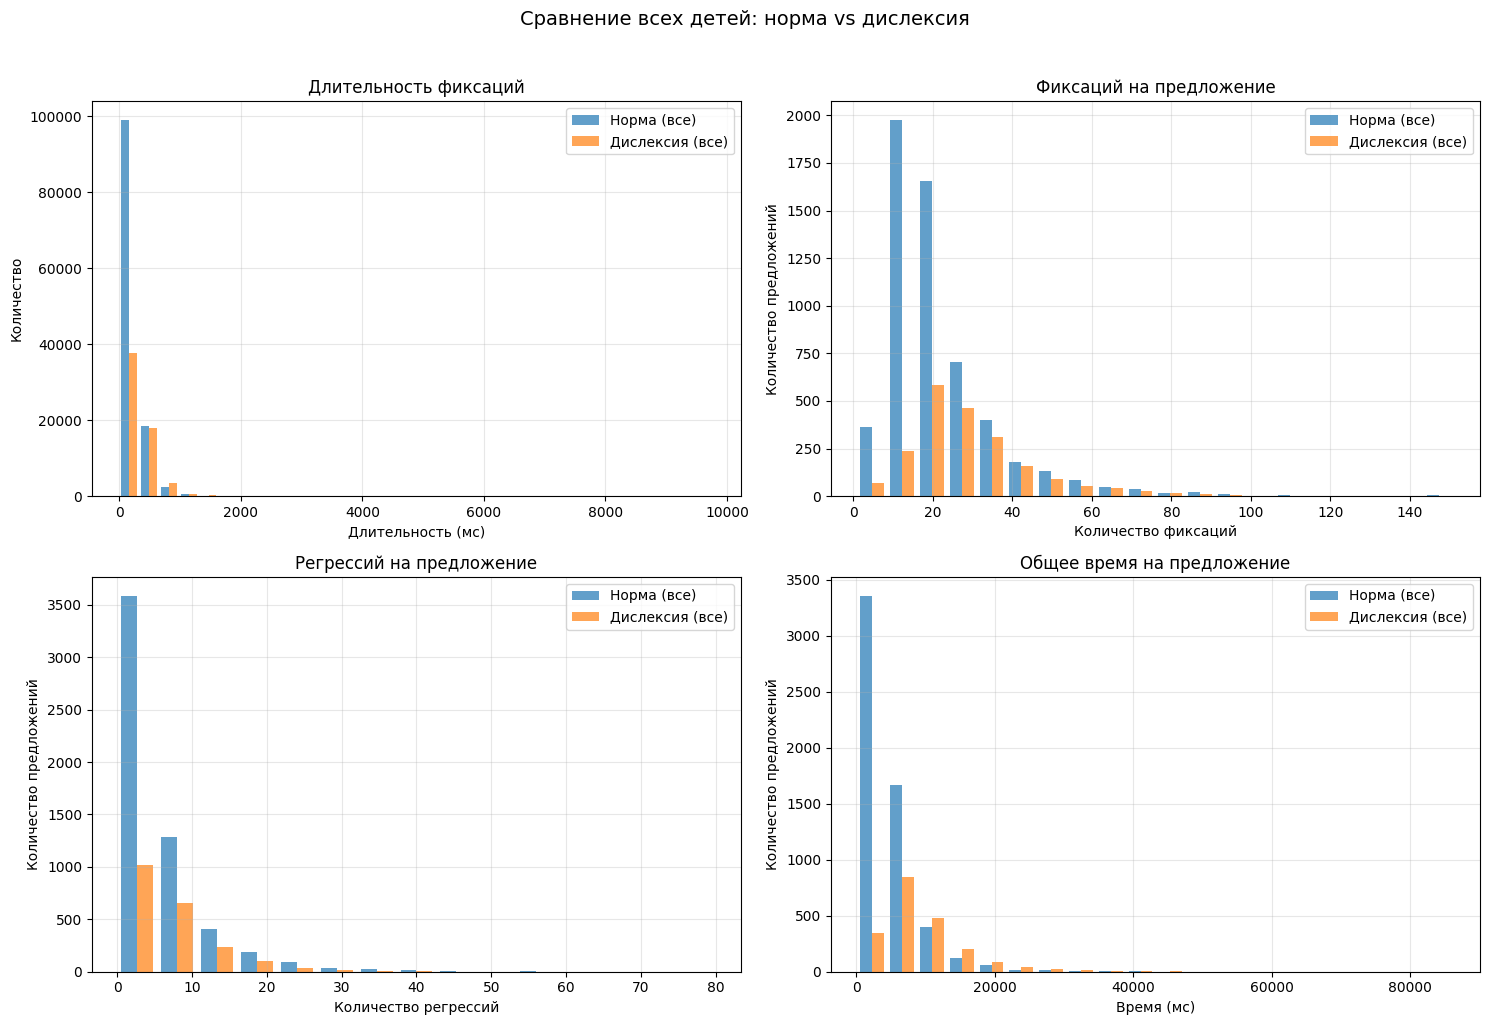

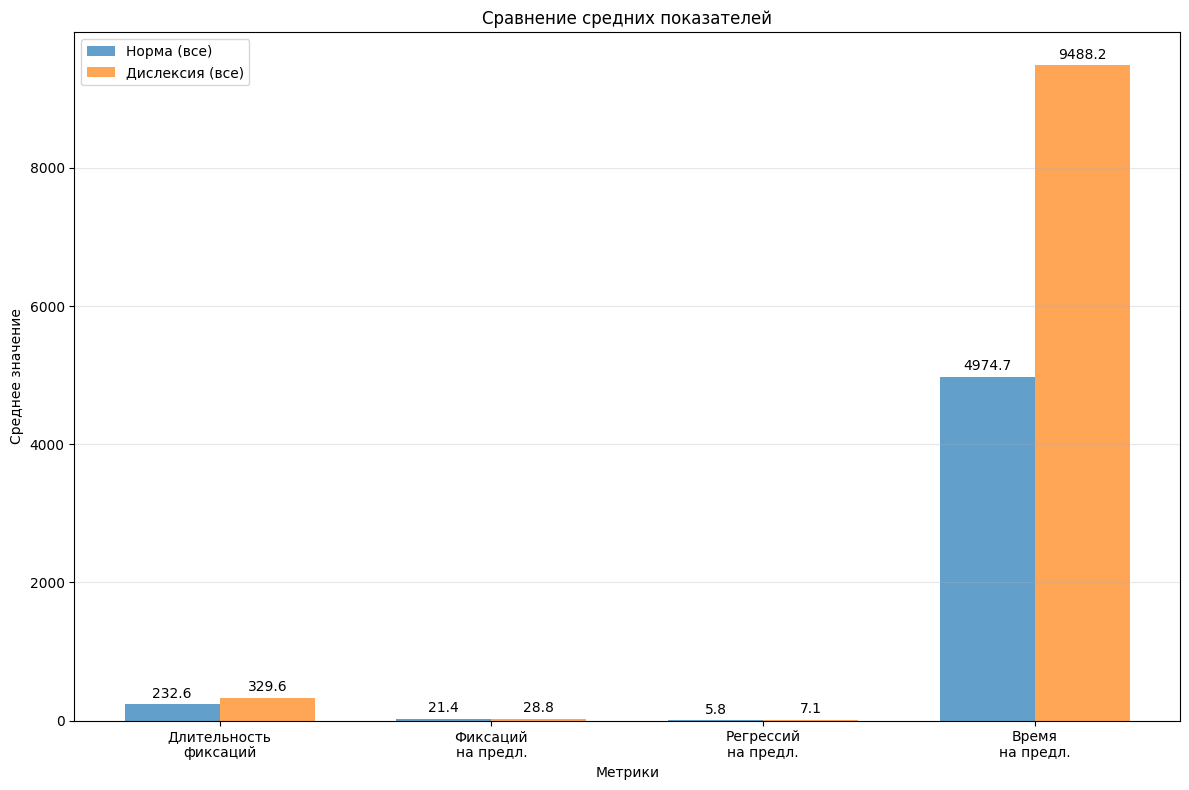

Норма: 189 детей, 120743 фиксаций
Дислексия: 72 детей, 59770 фиксаций


In [32]:
normal_ids = fixations[fixations['SubjectID'].isin(norm_socdem['SubjID'])]['SubjectID'].unique()
dyslexic_ids = fixations[fixations['SubjectID'].isin(dyslexia_socdem['SubjID'])]['SubjectID'].unique()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

normal_duration = fixations[fixations['SubjectID'].isin(normal_ids)]['FIX_DURATION']
dyslexic_duration = fixations[fixations['SubjectID'].isin(dyslexic_ids)]['FIX_DURATION']

axes[0, 0].hist([normal_duration, dyslexic_duration],
                bins=30,
                label=['Норма (все)', 'Дислексия (все)'],
                alpha=0.7)
axes[0, 0].set_title('Длительность фиксаций')
axes[0, 0].set_xlabel('Длительность (мс)')
axes[0, 0].set_ylabel('Количество')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

normal_fix_count = fixations[fixations['SubjectID'].isin(normal_ids)].groupby(['SubjectID', 'Sentence_ID']).size()
dyslexic_fix_count = fixations[fixations['SubjectID'].isin(dyslexic_ids)].groupby(['SubjectID', 'Sentence_ID']).size()

axes[0, 1].hist([normal_fix_count / , dyslexic_fix_count],
                bins=20,
                label=['Норма (все)', 'Дислексия (все)'],
                alpha=0.7)
axes[0, 1].set_title('Фиксаций на предложение')
axes[0, 1].set_xlabel('Количество фиксаций')
axes[0, 1].set_ylabel('Количество предложений')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Количество регрессий
def count_regressions_per_sentence(group):
    regressions = 0
    for i in range(1, len(group)):
        if group.iloc[i]['FIX_X'] < group.iloc[i-1]['FIX_X']:
            regressions += 1
    return regressions


normal_regressions = []
dyslexic_regressions = []

for subj_id in normal_ids:
    for sent_id in fixations['Sentence_ID'].unique():
        subset = fixations[(fixations['SubjectID'] == subj_id) &
                          (fixations['Sentence_ID'] == sent_id)]
        if len(subset) > 0:
            normal_regressions.append(count_regressions_per_sentence(subset))

for subj_id in dyslexic_ids:
    for sent_id in fixations['Sentence_ID'].unique():
        subset = fixations[(fixations['SubjectID'] == subj_id) &
                          (fixations['Sentence_ID'] == sent_id)]
        if len(subset) > 0:
            dyslexic_regressions.append(count_regressions_per_sentence(subset))

axes[1, 0].hist([normal_regressions, dyslexic_regressions],
                bins=15,
                label=['Норма (все)', 'Дислексия (все)'],
                alpha=0.7)
axes[1, 0].set_title('Регрессий на предложение')
axes[1, 0].set_xlabel('Количество регрессий')
axes[1, 0].set_ylabel('Количество предложений')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Среднее время на предложение
normal_time = fixations[fixations['SubjectID'].isin(normal_ids)].groupby(['SubjectID', 'Sentence_ID'])['FIX_DURATION'].sum()
dyslexic_time = fixations[fixations['SubjectID'].isin(dyslexic_ids)].groupby(['SubjectID', 'Sentence_ID'])['FIX_DURATION'].sum()

axes[1, 1].hist([normal_time, dyslexic_time],
                bins=20,
                label=['Норма (все)', 'Дислексия (все)'],
                alpha=0.7)
axes[1, 1].set_title('Общее время на предложение')
axes[1, 1].set_xlabel('Время (мс)')
axes[1, 1].set_ylabel('Количество предложений')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Сравнение всех детей: норма vs дислексия', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Статистика сравнения
fig, ax = plt.subplots(figsize=(12, 8))

metrics = ['Длительность\nфиксаций', 'Фиксаций\nна предл.', 'Регрессий\nна предл.', 'Время\nна предл.']
normal_means = [
    normal_duration.mean(),
    normal_fix_count.mean(),
    np.mean(normal_regressions),
    normal_time.mean()
]
dyslexic_means = [
    dyslexic_duration.mean(),
    dyslexic_fix_count.mean(),
    np.mean(dyslexic_regressions),
    dyslexic_time.mean()
]

x = np.arange(len(metrics))
width = 0.35

ax.bar(x - width/2, normal_means, width, label='Норма (все)', alpha=0.7)
ax.bar(x + width/2, dyslexic_means, width, label='Дислексия (все)', alpha=0.7)

ax.set_xlabel('Метрики')
ax.set_ylabel('Среднее значение')
ax.set_title('Сравнение средних показателей')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

for i in range(len(metrics)):
    ax.text(i - width/2, normal_means[i] + 0.01*max(normal_means+dyslexic_means),
            f'{normal_means[i]:.1f}', ha='center')
    ax.text(i + width/2, dyslexic_means[i] + 0.01*max(normal_means+dyslexic_means),
            f'{dyslexic_means[i]:.1f}', ha='center')

plt.tight_layout()
plt.show()

print(f"Норма: {len(normal_ids)} детей, {len(normal_duration)} фиксаций")
print(f"Дислексия: {len(dyslexic_ids)} детей, {len(dyslexic_duration)} фиксаций")

 Посмотрим на распределение точек фиксаций для детей без дислексии и с ней

In [12]:
def show_fixation(subject_id, sentence_id, color):
    plt.scatter(fixations[(fixations['SubjectID'] == subject_id) & (fixations['Sentence_ID'] == sentence_id)]['FIX_X'],
            fixations[(fixations['SubjectID'] == subject_id) & (fixations['Sentence_ID'] == sentence_id)]['FIX_Y'],
            alpha=0.6, color=color, label=f"Предложение {sentence_id}" )
    plt.legend()

Для начала посмотрим на несколько примеров фиксаций на словах для ребенка без дислексии

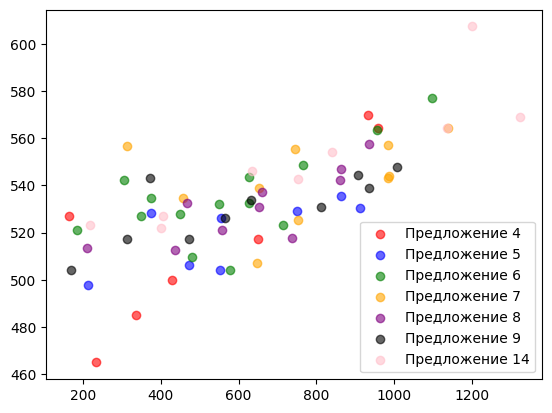

In [14]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'black', 'pink']
for i, n in enumerate([4, 5, 6, 7, 8, 9, 14]):
    show_fixation(2, n, colors[i])


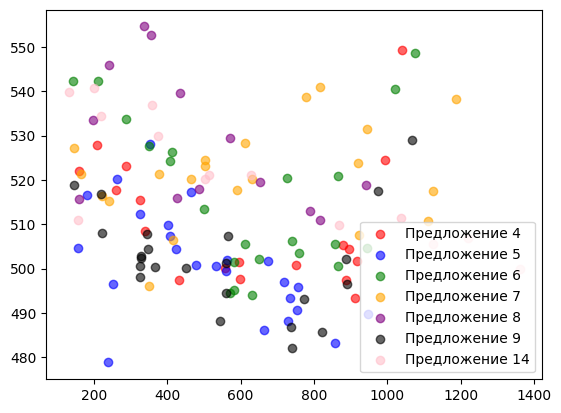

In [15]:
for i, n in enumerate([4, 5, 6, 7, 8, 9, 14]):
    show_fixation(11, n, colors[i])

Теперь посмотрим на те же фиксации для ребенка с дислексией

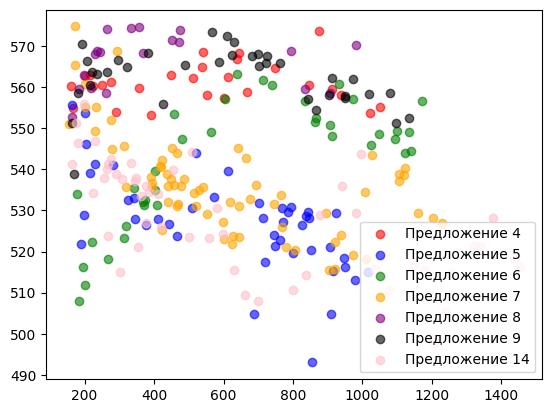

In [16]:

for i, n in enumerate([4, 5, 6, 7, 8, 9, 14]):
    show_fixation('ake05', n, colors[i])


Для начала надо заметить, что все предложения в одном месте, то есть давались детям поотдельности

Так же по графикам можно заметить, что хорошими признаками могут быть: количество фиксаций на предложение, количество регрессий

Посмотрим теперь на графы фиксаций для ребенка без дислексии и с ней

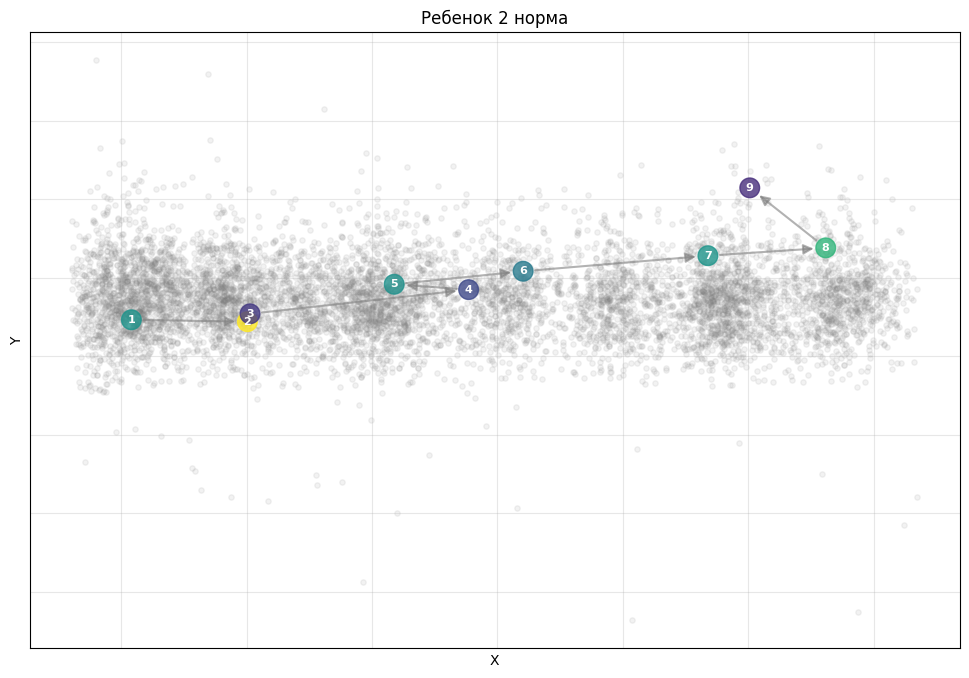

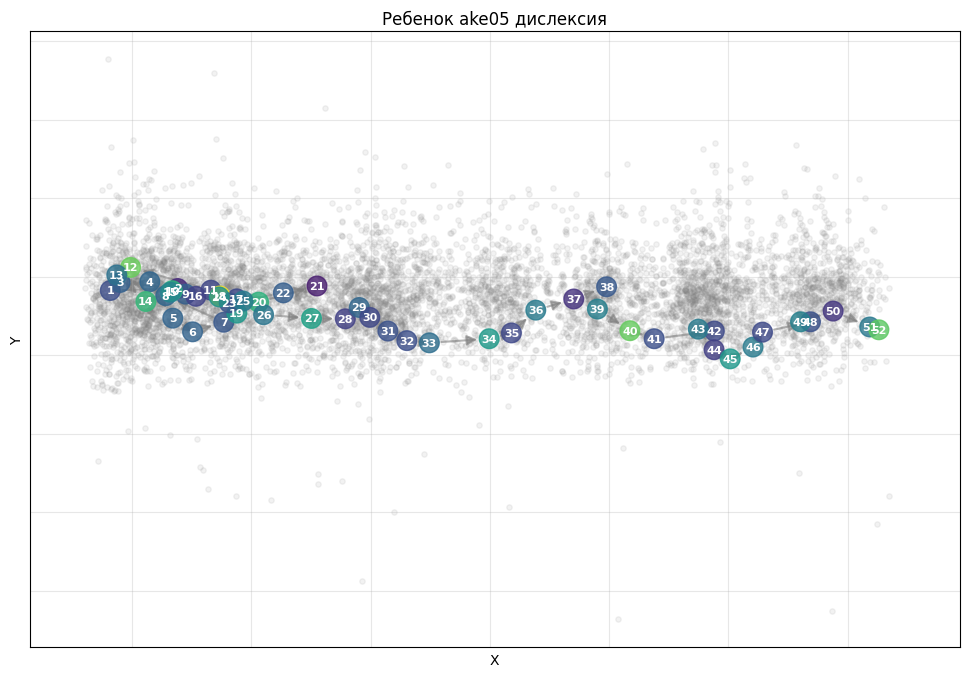

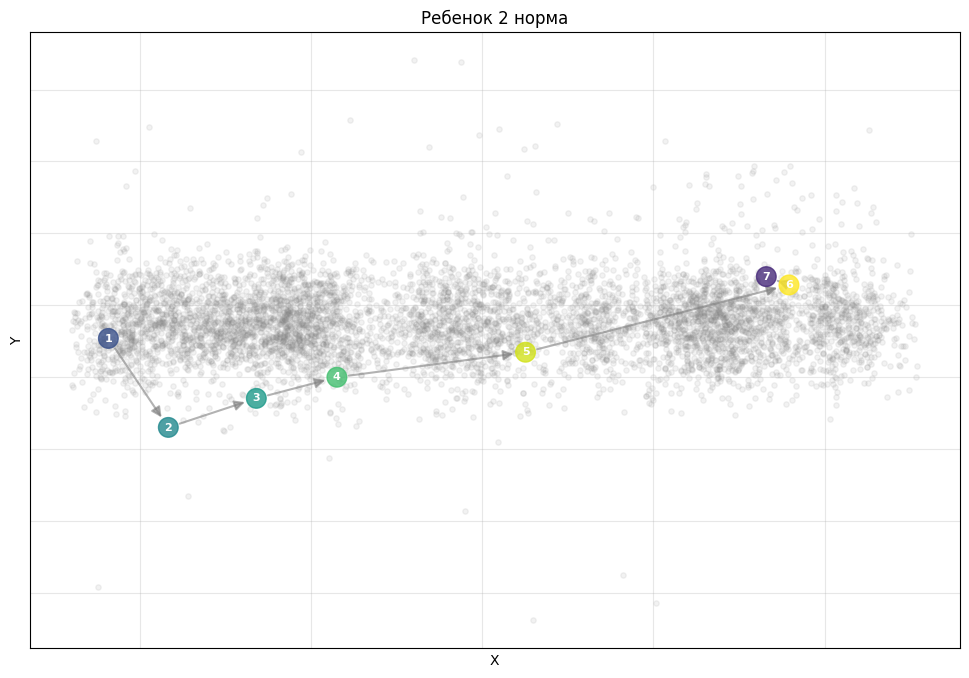

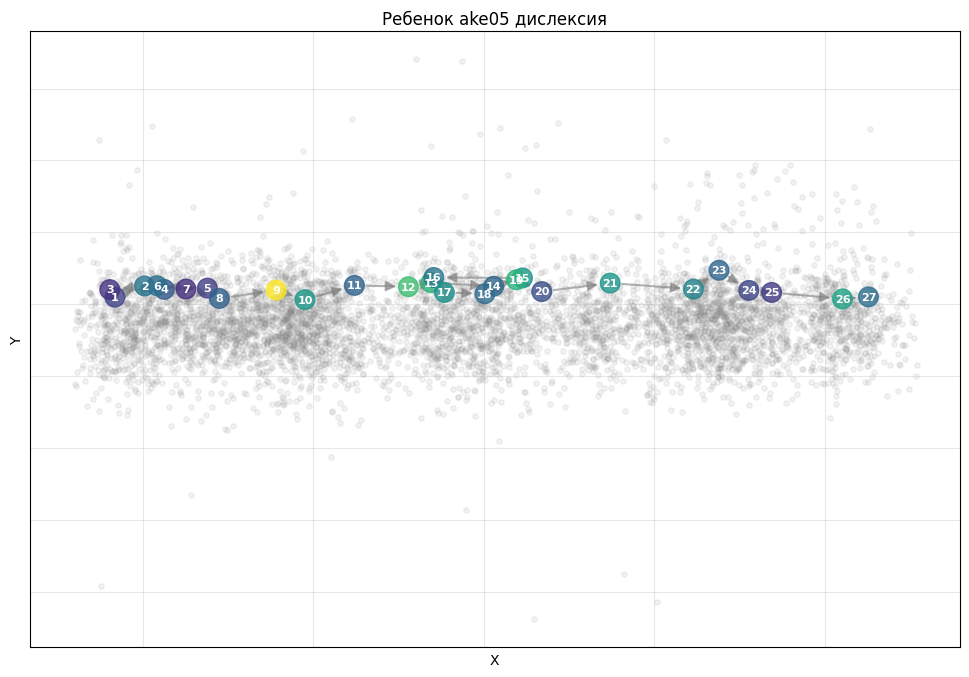

In [27]:
import networkx as nx

def create_fixation_graph(subject_id, sentence_id, title):
    subset = fixations[
        (fixations['SubjectID'] == subject_id) &
        (fixations['Sentence_ID'] == sentence_id)
    ].copy()
    subset['Fixation_Index'] = range(1, len(subset) + 1)

    G = nx.DiGraph()
    for idx, row in subset.iterrows():
        G.add_node(
            int(row['Fixation_Index']),
            pos=(row['FIX_X'], row['FIX_Y']),
            duration=row['FIX_DURATION'],
            word=row['Word_Number']
        )

    for i in range(len(subset) - 1):
        G.add_edge(
            int(subset.iloc[i]['Fixation_Index']),
            int(subset.iloc[i + 1]['Fixation_Index'])
        )

    return G, subset

def visualize_reading_graph(subject_id, sentence_id, title):
    fig, ax = plt.subplots(figsize=(12, 8))
    sent = str(sentences[sentences['number'] == sentence_id]['sentence'].iloc[0])

    all_fixations = fixations[fixations['Sentence_ID'] == sentence_id]
    ax.scatter(
        all_fixations['FIX_X'],
        all_fixations['FIX_Y'],
        alpha=0.1,
        color='gray',
        s=15
    )

    G, subset = create_fixation_graph(subject_id, sentence_id, title)
    pos = nx.get_node_attributes(G, 'pos')

    durations = nx.get_node_attributes(G, 'duration')
    norm_durations = [durations[node] / max(durations.values()) for node in G.nodes()]
    colors = plt.cm.viridis(norm_durations)

    nx.draw_networkx_nodes(
        G, pos,
        node_color=colors,
        node_size=200,
        ax=ax,
        alpha=0.8
    )
    nx.draw_networkx_edges(
        G, pos,
        ax=ax,
        arrows=True,
        arrowsize=15,
        edge_color='gray',
        width=1.5,
        alpha=0.6
    )

    labels = {node: str(node) for node in G.nodes()}
    nx.draw_networkx_labels(
        G, pos,
        labels,
        font_size=8,
        font_weight='bold',
        font_color='white',
        ax=ax
    )

    ax.set_title(f"{title}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid(True, alpha=0.3)
    return plt, ax

fig1, ax1 = visualize_reading_graph(2, 14, "Ребенок 2 норма")
plt.show()

fig2, ax2 = visualize_reading_graph('ake05', 14, "Ребенок ake05 дислексия")
plt.show()

fig3, ax3 = visualize_reading_graph(2, 4, "Ребенок 2 норма")
plt.show()

fig4, ax4 = visualize_reading_graph('ake05', 4, "Ребенок ake05 дислексия")
plt.show()

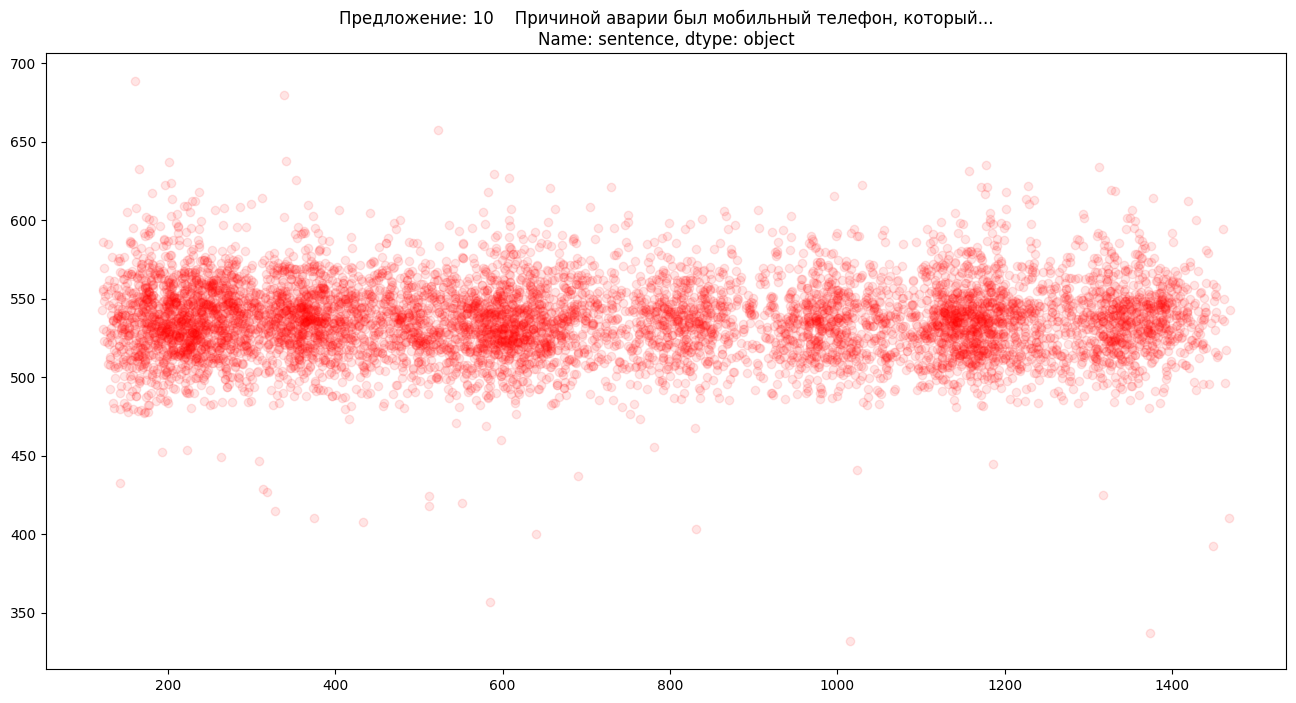

In [26]:
plt.figure(figsize=(16, 8))
sent = str(sentences[sentences['number'] == 14]['sentence'])
plt.scatter(fixations[fixations['Sentence_ID'] == 14]['FIX_X'], fixations[fixations['Sentence_ID'] == 14]['FIX_Y'], alpha=0.1, color = 'red')

plt.title(f'Предложение: { sent }');

In [45]:
ids = set(dyslexia_socdem['SubjID'])
ids.update(norm_socdem['SubjID'])
len(fixations[fixations['SubjectID'].isin(ids)])

180513

# Бейзлайн : Catboost на социально демографических признаках и признаковых описаниях путей

Для начала соберем признаки для каждого ребенка: соцдем + агрегированные признаки по фиксациям на предложениях

In [17]:
def compute_sentence_level_features(fixations_df):
    features_by_sentence = []

    grouped = fixations_df.groupby(['SubjectID', 'Sentence_ID']) # сгруппируем пары ребенок - предложение

    for (subject_id, sentence_id), group in grouped:
        if len(group) < 2:
            continue

        features = {
            'SubjectID': subject_id,
            'Sentence_ID': sentence_id,
            'fix_count': len(group),                                # количество фиксаций у дислексиков обычно больше
            'total_duration': group['FIX_DURATION'].sum(),          # длительность фиксаций тоже обычно больше
            'mean_fix_duration': group['FIX_DURATION'].mean(),      # среднее
            'std_fix_duration': group['FIX_DURATION'].std()         # стандартное отклонение
        }

        features['mean_fix_x'] = group['FIX_X'].mean()
        features['mean_fix_y'] = group['FIX_Y'].mean()
        features['std_fix_x'] = group['FIX_X'].std()
        features['std_fix_y'] = group['FIX_Y'].std()

        dx = group['FIX_X'].diff().iloc[1:]                         # скачок по оси x
        dy = group['FIX_Y'].diff().iloc[1:]                         # скачок по оси y
        saccade_amplitudes = np.sqrt(dx**2 + dy**2)                 # длина скачка

        features['mean_saccade_amp'] = saccade_amplitudes.mean()    # средняя длина
        features['max_saccade_amp'] = saccade_amplitudes.max() if len(saccade_amplitudes) > 0 else 0 # максимальная длина (например смотрит через слово)


        x_movements = group['FIX_X'].diff().iloc[1:]
        regressions = (x_movements < 0).sum()                       # количество регрессий (возвращений по тексту)
        features['regression_count'] = regressions
        features['regression_ratio'] = regressions / max(1, len(x_movements)) # доля

        fix_order = np.arange(len(group))
        x_coords = group['FIX_X'].values
        if len(set(x_coords)) > 1:
            x_scan_corr = np.corrcoef(fix_order, x_coords)[0, 1]
            features['scan_regularity'] = x_scan_corr if not np.isnan(x_scan_corr) else 0 # корреляция между координатами и номером слова
        else:                                                                             # 1 - читает слева направо, 0 - читает хаотично
            features['scan_regularity'] = 0

        words_in_sentence = group['Word_Number'].max()
        if words_in_sentence > 0:
            features['time_per_word'] = features['total_duration'] / words_in_sentence    # среднее время на слово

        features_by_sentence.append(features)

    return pd.DataFrame(features_by_sentence)

sentence_features = compute_sentence_level_features(fixations)
sentence_features.head(10)

,SubjectID,Sentence_ID,fix_count,total_duration,mean_fix_duration,std_fix_duration,mean_fix_x,mean_fix_y,std_fix_x,std_fix_y,mean_saccade_amp,max_saccade_amp,regression_count,regression_ratio,scan_regularity,time_per_word
0,2,4,7,974,139.142857,79.811086,528.828571,518.328571,324.177512,38.966255,142.261685,311.535295,1,0.166667,0.969461,139.142857
1,2,5,8,1167,145.875000,71.315071,586.412500,519.762500,241.937220,14.545587,183.110403,310.445390,2,0.285714,0.892220,145.875000
2,2,6,14,2470,176.428571,63.383709,575.785714,534.778571,251.383216,19.513592,176.185482,724.230516,4,0.307692,0.204697,274.444444
3,2,7,10,1434,143.400000,76.279020,766.490000,542.620000,260.795908,17.202248,151.372551,338.807349,2,0.222222,0.687585,179.250000
4,2,8,10,989,98.900000,52.528193,638.080000,531.220000,225.811750,15.098771,141.460013,301.041525,2,0.222222,0.863336,123.625000
5,2,9,10,1937,193.700000,71.366114,618.710000,530.350000,289.048856,14.160528,185.482027,563.713491,3,0.333333,0.625088,322.833333
6,2,10,6,1170,195.000000,30.893365,632.000000,544.300000,320.090793,7.278187,160.939380,276.439957,0,0.000000,0.990289,167.142857
7,2,11,8,1134,141.750000,73.755871,571.087500,529.000000,299.130795,34.879712,130.230760,230.842132,1,0.142857,0.989243,162.000000
8,2,12,10,1547,154.700000,88.327736,600.480000,533.420000,315.633831,21.595977,171.548467,450.852748,1,0.111111,0.858329,171.888889
9,2,13,5,1379,275.800000,253.228553,489.480000,517.580000,264.442030,8.807213,169.961509,274.931646,0,0.000000,0.986141,229.833333


In [18]:
dyslexia_socdem['dyslexia'] = 1
norm_socdem['dyslexia'] = 0
all_children = pd.concat([dyslexia_socdem, norm_socdem])
all_features = pd.merge(sentence_features, all_children, how='left', left_on='SubjectID', right_on='SubjID')
all_features.head()

,SubjectID,Sentence_ID,fix_count,total_duration,mean_fix_duration,std_fix_duration,mean_fix_x,mean_fix_y,std_fix_x,std_fix_y,...,regression_ratio,scan_regularity,time_per_word,Group,SubjID,Sex,Grade,Age,IQ,dyslexia
0,2,4,7,974,139.142857,79.811086,528.828571,518.328571,324.177512,38.966255,...,0.166667,0.969461,139.142857,norm,2,m,4.0,10.0,34.0,0.0
1,2,5,8,1167,145.875000,71.315071,586.412500,519.762500,241.937220,14.545587,...,0.285714,0.892220,145.875000,norm,2,m,4.0,10.0,34.0,0.0
2,2,6,14,2470,176.428571,63.383709,575.785714,534.778571,251.383216,19.513592,...,0.307692,0.204697,274.444444,norm,2,m,4.0,10.0,34.0,0.0
3,2,7,10,1434,143.400000,76.279020,766.490000,542.620000,260.795908,17.202248,...,0.222222,0.687585,179.250000,norm,2,m,4.0,10.0,34.0,0.0
4,2,8,10,989,98.900000,52.528193,638.080000,531.220000,225.811750,15.098771,...,0.222222,0.863336,123.625000,norm,2,m,4.0,10.0,34.0,0.0


Поскольку нам надо определять дислексию ребенка в целом, а не на конкретном предложение, то объединим данные на уровне ребенка

In [19]:
child_data = []

for subject_id in all_features['SubjectID'].unique():
    child_rows = all_features[all_features['SubjectID'] == subject_id]

    stats = {
        'SubjectID': subject_id,
        'fix_duration_mean': child_rows['mean_fix_duration'].mean(),
        'fix_duration_std': child_rows['mean_fix_duration'].std(),
        'regression_ratio_mean': child_rows['regression_ratio'].mean(),
        'regression_ratio_std': child_rows['regression_ratio'].std(),
        'scan_regularity_mean': child_rows['scan_regularity'].mean(),
        'scan_regularity_std': child_rows['scan_regularity'].std(),
        'saccade_amp_mean': child_rows['mean_saccade_amp'].mean(),
        'time_per_word_mean': child_rows['time_per_word'].mean(),

        'Age': child_rows['Age'].iloc[0],
        'Sex': child_rows['Sex'].iloc[0],
        'IQ': child_rows['IQ'].iloc[0],
        'Grade': child_rows['Grade'].iloc[0],
        'dyslexia': child_rows['dyslexia'].iloc[0]
    }

    stats['worst_regression_ratio'] = child_rows['regression_ratio'].max()
    stats['best_scan_regularity'] = child_rows['scan_regularity'].min()

    child_data.append(stats)

child_features_df = pd.DataFrame(child_data)
child_features_df.head()

,SubjectID,fix_duration_mean,fix_duration_std,regression_ratio_mean,regression_ratio_std,scan_regularity_mean,scan_regularity_std,saccade_amp_mean,time_per_word_mean,Age,Sex,IQ,Grade,dyslexia,worst_regression_ratio,best_scan_regularity
0,2,159.923208,41.430798,0.183112,0.108848,0.819756,0.251789,156.897208,201.898042,10.0,m,34.0,4.0,0.0,0.333333,0.078459
1,3,115.106455,24.380467,0.260373,0.090469,0.824605,0.253749,75.600016,374.787765,10.0,m,36.0,4.0,0.0,0.400000,0.028846
2,4,117.878023,26.323828,0.351349,0.099281,0.821143,0.229821,109.740942,284.469312,10.0,f,33.0,4.0,0.0,0.666667,0.205560
3,6,199.631303,30.960462,0.303687,0.112905,0.817368,0.204352,97.686176,511.645833,9.0,f,33.0,4.0,0.0,0.480000,0.392512
4,9,169.177901,22.376263,0.277604,0.103815,0.751223,0.283497,88.942039,490.297817,10.0,f,29.0,4.0,0.0,0.437500,0.119732


In [20]:
child_features_df = child_features_df.dropna(subset=['dyslexia'])
child_features_df = child_features_df.drop('SubjectID', axis=1)

## Catboost на несбалансированных данных

Разделим данные и обучим CatboostClassifier с class_weights, потому что классы несбалансированы

In [21]:
X = child_features_df.drop('dyslexia', axis=1)
y = child_features_df['dyslexia']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [22]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()
cb_model_1 = CatBoostClassifier(
    cat_features=cat_features,
    class_weights=[1, scale_pos_weight],
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    early_stopping_rounds=50,
    verbose=100
)

In [23]:
cb_model_1.fit(X_train, y_train)
cb_model_predict_1 = cb_model_1.predict(X_test)

recall_dyslexia = recall_score(y_test, cb_model_predict_1, pos_label=1)


balanced_recall_1 = recall_score(y_test, cb_model_predict_1, average='macro')

balanced_recall_2 = recall_score(y_test, cb_model_predict_1, average='weighted')
print(f"Recall дислексии: {recall_dyslexia:.3f}")
print(f"Balanced recall: {balanced_recall_1:.3f}")
print(f"Balanced recall: {balanced_recall_2:.3f}")


0:	total: 58.5ms	remaining: 58.5s
100:	total: 951ms	remaining: 8.46s
200:	total: 1.78s	remaining: 7.06s
300:	total: 2.36s	remaining: 5.48s
400:	total: 2.71s	remaining: 4.04s
500:	total: 2.97s	remaining: 2.96s
600:	total: 3.65s	remaining: 2.42s
700:	total: 3.99s	remaining: 1.7s
800:	total: 4.63s	remaining: 1.15s
900:	total: 5.33s	remaining: 586ms
999:	total: 5.93s	remaining: 0us
Recall дислексии: 0.533
Balanced recall: 0.727
Balanced recall: 0.811


In [24]:
cm = confusion_matrix(y_test, cb_model_predict_1)
print(cm)

[[35  3]
 [ 7  8]]


## Catboost на сбалансированных данных
Тепрерь сделаем undersampling 0 класса и обучимся на сбалансированных данных

In [25]:
from sklearn.utils import resample
df_tmp = pd.concat([X, y], axis=1)
df_majority = df_tmp[df_tmp[y.name] == 0]
df_minority = df_tmp[df_tmp[y.name] == 1]
df_majority_undersampled = resample(
    df_majority,
    replace=False,
    n_samples=len(df_minority),
    random_state=42
)

df_undersampled = pd.concat([df_majority_undersampled, df_minority])
df_undersampled['dyslexia'].value_counts()

,count
dyslexia,
0.0,72
1.0,72


In [26]:
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
                                                                        df_undersampled.drop('dyslexia', axis=1),
                                                                        df_undersampled['dyslexia'],
                                                                        stratify=df_undersampled['dyslexia'],
                                                                        shuffle=True,
                                                                        random_state=239,
                                                                        test_size=0.2)

In [27]:
cb_model_2 = CatBoostClassifier(
    cat_features=cat_features,
    iterations=2000,
    learning_rate=0.01,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    early_stopping_rounds=50,
    verbose=100
)
cb_model_2.fit(X_train_balanced, y_train_balanced)
cb_model_predict_2 = cb_model_2.predict(X_test_balanced)
recall_dyslexia_balanced = recall_score(y_test_balanced, cb_model_predict_2, pos_label=1)

print(f"Recall дислексии: {recall_dyslexia_balanced:.3f}")

0:	total: 1.85ms	remaining: 3.71s
100:	total: 127ms	remaining: 2.4s
200:	total: 269ms	remaining: 2.4s
300:	total: 402ms	remaining: 2.27s
400:	total: 534ms	remaining: 2.13s
500:	total: 671ms	remaining: 2.01s
600:	total: 814ms	remaining: 1.9s
700:	total: 961ms	remaining: 1.78s
800:	total: 1.12s	remaining: 1.68s
900:	total: 1.33s	remaining: 1.62s
1000:	total: 1.51s	remaining: 1.51s
1100:	total: 1.85s	remaining: 1.51s
1200:	total: 2.25s	remaining: 1.5s
1300:	total: 2.63s	remaining: 1.41s
1400:	total: 3s	remaining: 1.28s
1500:	total: 3.34s	remaining: 1.11s
1600:	total: 3.47s	remaining: 864ms
1700:	total: 3.6s	remaining: 633ms
1800:	total: 3.72s	remaining: 411ms
1900:	total: 3.85s	remaining: 201ms
1999:	total: 3.98s	remaining: 0us
Recall дислексии: 0.786


In [28]:
cm = confusion_matrix(y_test_balanced, cb_model_predict_2)
print(cm)

[[10  5]
 [ 3 11]]


## Catboost GridserchCV
В целом для бейзлайна получился неплохой результат (уже лучше чем случайное угадывание)

Проведем подбор гиперпараметров с помощью кросс-валидации

In [29]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'depth': [6, 8],
    'learning_rate': [0.01, 0.03, 0.05],
    'iterations': [1000, 2000],
    'min_data_in_leaf': [1, 5, 20]
}

grid_search = GridSearchCV(
    estimator=cb_model_2,
    param_grid=param_grid,
    cv=cv,
    scoring='recall',
    n_jobs=-1,
    verbose=2,
    refit=True
)

grid_search.fit(X_train_balanced, y_train_balanced)


print("Best parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
cb_model_predict_2 = best_model.predict(X_test_balanced)
recall_dyslexia_balanced = recall_score(y_test_balanced, cb_model_predict_2, pos_label=1)
print(f"Recall дислексии with tuned model: {recall_dyslexia_balanced:.3f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0:	total: 5.42ms	remaining: 5.42s
100:	total: 375ms	remaining: 3.34s
200:	total: 724ms	remaining: 2.88s
300:	total: 1.08s	remaining: 2.5s
400:	total: 1.45s	remaining: 2.16s
500:	total: 1.8s	remaining: 1.79s
600:	total: 2.14s	remaining: 1.42s
700:	total: 2.51s	remaining: 1.07s
800:	total: 2.85s	remaining: 709ms
900:	total: 3.2s	remaining: 352ms
999:	total: 3.56s	remaining: 0us
Best parameters found:
depth: 8
iterations: 1000
learning_rate: 0.05
min_data_in_leaf: 1
Best CV score: 0.8258
Recall дислексии with tuned model: 0.857


In [30]:
from sklearn.metrics import precision_score, accuracy_score, f1_score
print("precision: ", precision_score(y_test_balanced, cb_model_predict_2))
print("accuracy: ", accuracy_score(y_test_balanced, cb_model_predict_2))
print("f1: ", f1_score(y_test_balanced, cb_model_predict_2))
cm = confusion_matrix(y_test_balanced, cb_model_predict_2)
print(cm)

precision:  0.75
accuracy:  0.7931034482758621
f1:  0.8
[[11  4]
 [ 2 12]]


# Применение методов глубокого обучения

## GINEClassifier

Попробуем первую модель на графах - GINEClassifier

Заново соберем признаки и начнем строить граф

In [31]:
FIX_PATH  = "Fixation_report_dyslexia.xlsx"
DEMO_PATH = "demo_groups.xlsx"
fix = pd.read_excel(FIX_PATH, sheet_name="data")
sent = pd.read_excel(FIX_PATH, sheet_name="Предложения")
dys  = pd.read_excel(DEMO_PATH, sheet_name="dyslexia")
norm = pd.read_excel(DEMO_PATH, sheet_name="norm")
norm["Sex"] = norm["Sex"].apply(lambda x: "f" if x == "fem" else "m")
labels = pd.concat([dys, norm], ignore_index=True).copy()
labels["target"] = (labels["Group"] == "dyslexia").astype(int)
labels = labels.rename(columns={"SubjID": "SubjectID"})[["SubjectID", "target", "Sex", "Age", "IQ", "Grade"]]
labels = labels[labels["SubjectID"].isin(fix["SubjectID"].unique())].reset_index(drop=True)
fix = fix[fix["SubjectID"].isin(labels["SubjectID"])].copy()

def count_words_ru(text):
    return len(re.findall(r"[A-Za-zА-Яа-яЁё0-9]+", str(text)))

sent["word_count"] = sent["sentence"].apply(count_words_ru)
sent_len = dict(zip(sent["number"], sent["word_count"]))


Для каждой пары ребенок - предложение строим свой граф, концепция: узлы - слова в предложении, ребра - саккады (перемещения) между словами

In [32]:
def build_word_graph_one_subject_sentence(df_ss, sentence_id):
    L = sent_len[int(sentence_id)]
    node_fix_count = np.zeros(L, dtype=np.float32)
    node_total_dur = np.zeros(L, dtype=np.float32)
    node_mean_dur  = np.zeros(L, dtype=np.float32)
    node_std_dur   = np.zeros(L, dtype=np.float32)
    node_firstpass = np.zeros(L, dtype=np.float32)

    for w in range(1, L+1):
        g = df_ss[df_ss["Word_Number"] == w]
        idx = w-1
        if len(g) == 0:
            continue
        node_fix_count[idx] = len(g)
        # считаем статистику для предложений
        node_total_dur[idx] = g["FIX_DURATION"].sum()
        node_mean_dur[idx]  = g["FIX_DURATION"].mean()
        node_std_dur[idx]   = g["FIX_DURATION"].std(ddof=0) if len(g) > 1 else 0.0

        # добавим еще статистику по первому вхождению слова в предложение
        first_row = g.iloc[0]
        node_firstpass[idx] = float(first_row["FIX_DURATION"])

    # нормированная позиция слова
    word_pos = np.linspace(0, 1, L, dtype=np.float32)
    eps = 1e-6
    total_dur_log = np.log1p(node_total_dur)
    mean_dur_log  = np.log1p(node_mean_dur)
    firstpass_log = np.log1p(node_firstpass)

    x = np.stack([
        node_fix_count,
        total_dur_log,
        mean_dur_log,
        node_std_dur,
        firstpass_log,
        word_pos
    ], axis=1).astype(np.float32)

    # Создаем ребра
    words = df_ss["Word_Number"].to_numpy().astype(int)
    xs = df_ss["FIX_X"].to_numpy().astype(np.float32)
    ys = df_ss["FIX_Y"].to_numpy().astype(np.float32)
    edge_src = []
    edge_dst = []
    edge_attr = []

    for i in range(len(df_ss) - 1):
        a = words[i]   - 1
        b = words[i+1] - 1
        if a < 0 or a >= L or b < 0 or b >= L:
            continue

        dx = xs[i+1] - xs[i]
        dy = ys[i+1] - ys[i]
        amp = float(np.sqrt(dx*dx + dy*dy))
        is_reg = 1.0 if (b < a) else 0.0 # проверяем является ли это регрессией

        edge_src.append(a); edge_dst.append(b)
        edge_attr.append([dx, dy, amp, is_reg])

    edge_index = np.stack([edge_src, edge_dst], axis=0).astype(np.int64)
    edge_attr  = np.array(edge_attr, dtype=np.float32)

    # собираем граф
    data = Data(
        x = torch.tensor(x, dtype=torch.float),
        edge_index = torch.tensor(edge_index, dtype=torch.long),
        edge_attr  = torch.tensor(edge_attr, dtype=torch.float),
    )
    return data


In [33]:
def build_dataset_word_graphs(fix, labels):
    lbl_map = dict(zip(labels["SubjectID"], labels["target"]))

    # Создаем словарь для чтобы закодировать числовыми ID потому что изначально они строковые, не подойдут для torch tensor
    unique_subjects = fix["SubjectID"].unique()
    subj_to_num = {subj: i for i, subj in enumerate(unique_subjects)}
    num_to_subj = {v: k for k, v in subj_to_num.items()}

    graphs = []
    for (subj, sid), df_ss in fix.groupby(["SubjectID", "Sentence_ID"], sort=False):
        if subj not in lbl_map:
            continue
        df_ss = df_ss.copy()
        g = build_word_graph_one_subject_sentence(df_ss, sid)
        g.y = torch.tensor([lbl_map[subj]], dtype=torch.long)
        g.subject_id = torch.tensor([subj_to_num[subj]], dtype=torch.long)  # Числовой ID!
        g.sentence_id = int(sid)
        graphs.append(g)

    # Возвращаем графы и словари
    return graphs, subj_to_num, num_to_subj

In [34]:
class GINEClassifier(nn.Module):
    def __init__(self, in_dim, edge_dim, hidden=64, num_layers=3, dropout=0.2):
        super().__init__()
        self.dropout = dropout

        self.node_enc = nn.Linear(in_dim, hidden)

        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            mlp = nn.Sequential(
                nn.Linear(hidden, hidden),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
            )
            self.convs.append(GINEConv(nn=mlp, edge_dim=edge_dim))

        self.head = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1)
        )

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.node_enc(x)
        for conv in self.convs:
            x = conv(x, edge_index, edge_attr)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        g = global_mean_pool(x, batch)
        logits = self.head(g).squeeze(-1)
        return logits


Строим граф для всех пар ребенок - предложение

In [35]:
graphs, subj_to_num, num_to_subj = build_dataset_word_graphs(fix, labels)
all_y = np.array([int(g.y.item()) for g in graphs])
all_groups = np.array([g.subject_id.item() for g in graphs])
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)


Построим функцию для оценки модели

In [36]:
def eval_subject_level(model, loader, num_to_subj=None):
    model.eval()
    subj_logits = {}
    subj_y = {}

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            logits = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            probs = torch.sigmoid(logits).detach().cpu().numpy()

            for i in range(len(probs)):
                num_id = int(batch.subject_id[i].item())
                sid = num_to_subj[num_id] if num_to_subj else str(num_id)
                y = int(batch.y[i].item())
                subj_y[sid] = y
                subj_logits.setdefault(sid, []).append(float(probs[i]))

    # агрегируем по ребёнку
    y_true = []
    y_prob = []
    for sid, plist in subj_logits.items():
        y_true.append(subj_y[sid])
        y_prob.append(np.mean(plist))

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    y_pred = (y_prob >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    return {
        "recall_dyslexia": recall_score(y_true, y_pred, pos_label=1),
        "balanced_acc": balanced_accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "auc": roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else np.nan,
        "n_subjects": len(y_true),
        "confusion_matrix": cm
    }

Цикл обучения:

In [38]:

for fold, (tr_idx, te_idx) in enumerate(sgkf.split(np.zeros(len(graphs)), all_y, groups=all_groups), 1):
    train_graphs = [graphs[i] for i in tr_idx]
    test_graphs  = [graphs[i] for i in te_idx]

    y_tr = np.array([int(g.y.item()) for g in train_graphs])
    neg = (y_tr == 0).sum()
    pos = (y_tr == 1).sum()
    pos_weight = torch.tensor([neg / max(pos, 1)], dtype=torch.float, device=device) # учитываем дисбаланс классов
    train_loader = DataLoader(train_graphs, batch_size=64, shuffle=True)
    test_loader  = DataLoader(test_graphs,  batch_size=128, shuffle=False)

    in_dim = train_graphs[0].x.size(1)
    edge_dim = train_graphs[0].edge_attr.size(1) if train_graphs[0].edge_attr.numel() else 4

    model = GINEClassifier(in_dim=in_dim, edge_dim=edge_dim, hidden=64, num_layers=3, dropout=0.2).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    best = -1
    for epoch in tqdm(range(1, 41)):
        model.train()
        total_loss = 0.0
        for batch in train_loader:
            batch = batch.to(device)
            opt.zero_grad()
            logits = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            y = batch.y.float().to(device)
            loss = criterion(logits, y)
            loss.backward()
            opt.step()
            total_loss += loss.item()

        metrics = eval_subject_level(model, test_loader, num_to_subj)
        score = metrics["recall_dyslexia"]
        if score > best:
            best = score

        if epoch % 10 == 0 or epoch == 1:
            print(f"[fold {fold}] epoch {epoch:02d} loss={total_loss/len(train_loader):.4f} "
                  f"recall={metrics['recall_dyslexia']:.3f} bal_acc={metrics['balanced_acc']:.3f} "
                  f"f1={metrics['f1']:.3f} auc={metrics['auc']:.3f}")
            print(metrics['confusion_matrix'])

  2%|▎         | 1/40 [00:02<01:31,  2.35s/it]

[fold 1] epoch 01 loss=1.5495 recall=0.615 bal_acc=0.731 f1=0.593 auc=0.876
[[33  6]
 [ 5  8]]


 25%|██▌       | 10/40 [00:16<00:36,  1.23s/it]

[fold 1] epoch 10 loss=0.8138 recall=1.000 bal_acc=0.833 f1=0.667 auc=0.870
[[26 13]
 [ 0 13]]


 50%|█████     | 20/40 [00:26<00:20,  1.03s/it]

[fold 1] epoch 20 loss=0.7753 recall=0.692 bal_acc=0.744 f1=0.600 auc=0.882
[[31  8]
 [ 4  9]]


 75%|███████▌  | 30/40 [00:36<00:10,  1.05s/it]

[fold 1] epoch 30 loss=0.7409 recall=0.923 bal_acc=0.833 f1=0.686 auc=0.901
[[29 10]
 [ 1 12]]


100%|██████████| 40/40 [00:52<00:00,  1.32s/it]


[fold 1] epoch 40 loss=0.7209 recall=0.846 bal_acc=0.833 f1=0.710 auc=0.917
[[32  7]
 [ 2 11]]


  2%|▎         | 1/40 [00:01<00:54,  1.39s/it]

[fold 2] epoch 01 loss=1.5729 recall=0.267 bal_acc=0.606 f1=0.381 auc=0.822
[[34  2]
 [11  4]]


 25%|██▌       | 10/40 [00:15<00:49,  1.64s/it]

[fold 2] epoch 10 loss=0.8293 recall=0.400 bal_acc=0.686 f1=0.545 auc=0.863
[[35  1]
 [ 9  6]]


 50%|█████     | 20/40 [00:34<00:35,  1.75s/it]

[fold 2] epoch 20 loss=0.8161 recall=0.733 bal_acc=0.797 f1=0.710 auc=0.854
[[31  5]
 [ 4 11]]


 75%|███████▌  | 30/40 [00:47<00:11,  1.19s/it]

[fold 2] epoch 30 loss=0.9127 recall=0.733 bal_acc=0.769 f1=0.667 auc=0.831
[[29  7]
 [ 4 11]]


100%|██████████| 40/40 [01:00<00:00,  1.51s/it]


[fold 2] epoch 40 loss=0.8470 recall=0.800 bal_acc=0.817 f1=0.727 auc=0.865
[[30  6]
 [ 3 12]]


  2%|▎         | 1/40 [00:01<01:06,  1.70s/it]

[fold 3] epoch 01 loss=1.8699 recall=0.385 bal_acc=0.654 f1=0.476 auc=0.791
[[36  3]
 [ 8  5]]


 25%|██▌       | 10/40 [00:14<00:36,  1.21s/it]

[fold 3] epoch 10 loss=0.8201 recall=0.538 bal_acc=0.718 f1=0.583 auc=0.842
[[35  4]
 [ 6  7]]


 50%|█████     | 20/40 [00:26<00:24,  1.24s/it]

[fold 3] epoch 20 loss=0.7712 recall=0.769 bal_acc=0.769 f1=0.625 auc=0.862
[[30  9]
 [ 3 10]]


 75%|███████▌  | 30/40 [00:47<00:22,  2.22s/it]

[fold 3] epoch 30 loss=0.7121 recall=0.538 bal_acc=0.718 f1=0.583 auc=0.880
[[35  4]
 [ 6  7]]


100%|██████████| 40/40 [01:06<00:00,  1.66s/it]


[fold 3] epoch 40 loss=0.7174 recall=0.769 bal_acc=0.769 f1=0.625 auc=0.874
[[30  9]
 [ 3 10]]


  2%|▎         | 1/40 [00:01<01:03,  1.63s/it]

[fold 4] epoch 01 loss=1.4310 recall=0.733 bal_acc=0.709 f1=0.579 auc=0.777
[[26 12]
 [ 4 11]]


 25%|██▌       | 10/40 [00:20<01:15,  2.53s/it]

[fold 4] epoch 10 loss=0.8384 recall=0.800 bal_acc=0.768 f1=0.649 auc=0.835
[[28 10]
 [ 3 12]]


 50%|█████     | 20/40 [00:38<00:35,  1.76s/it]

[fold 4] epoch 20 loss=0.8297 recall=0.867 bal_acc=0.775 f1=0.650 auc=0.844
[[26 12]
 [ 2 13]]


 75%|███████▌  | 30/40 [00:56<00:15,  1.56s/it]

[fold 4] epoch 30 loss=0.7762 recall=0.867 bal_acc=0.802 f1=0.684 auc=0.856
[[28 10]
 [ 2 13]]


100%|██████████| 40/40 [01:13<00:00,  1.85s/it]


[fold 4] epoch 40 loss=0.8355 recall=0.933 bal_acc=0.756 f1=0.622 auc=0.858
[[22 16]
 [ 1 14]]


  2%|▎         | 1/40 [00:02<01:30,  2.32s/it]

[fold 5] epoch 01 loss=1.7660 recall=0.500 bal_acc=0.669 f1=0.533 auc=0.816
[[31  6]
 [ 8  8]]


 25%|██▌       | 10/40 [00:18<00:49,  1.66s/it]

[fold 5] epoch 10 loss=0.8537 recall=0.500 bal_acc=0.655 f1=0.516 auc=0.785
[[30  7]
 [ 8  8]]


 50%|█████     | 20/40 [00:36<00:33,  1.70s/it]

[fold 5] epoch 20 loss=0.7906 recall=0.875 bal_acc=0.748 f1=0.636 auc=0.799
[[23 14]
 [ 2 14]]


 75%|███████▌  | 30/40 [00:53<00:17,  1.74s/it]

[fold 5] epoch 30 loss=0.7653 recall=0.875 bal_acc=0.775 f1=0.667 auc=0.801
[[25 12]
 [ 2 14]]


100%|██████████| 40/40 [01:12<00:00,  1.80s/it]

[fold 5] epoch 40 loss=0.7440 recall=0.625 bal_acc=0.745 f1=0.645 auc=0.861
[[32  5]
 [ 6 10]]


## Transformer на последовательностях

Теперь отойдем от графов и попробуем обучить трансформер на последовательностях фиксаций (во времени)

Для каждого объекта - одна последовательность

8 признаков :
- x_norm, y_norm - координаты, нормализованные внутри последовательности
- log_dur - логарифм длительности фиксации
- word_norm - позиция слова, нормализованная от 0 до 1
- dx, dy - движение взгляда от предыдущей фиксации
- amp - амплитуда движения (длина саккады)
- is_reg - регрессия (движение назад по тексту)

In [ ]:
unique_subjects = fix["SubjectID"].unique()
subj_to_num = {s: i for i, s in enumerate(unique_subjects)}
num_to_subj = {i: s for s, i in subj_to_num.items()}
ORDER_COL_CANDIDATES = [
    "Fixation_Index", "FixationIndex", "Fixation_Number", "FixationNumber",
    "Fixation_ID", "FixationID", "FIXATION_INDEX", "FIXATION_NUMBER",
    "timestamp", "time", "Time"
]
def maybe_sort_df(df):
    for c in ORDER_COL_CANDIDATES:
        if c in df.columns:
            return df.sort_values(c, kind="mergesort")
    return df

Класс для датасетов:


In [ ]:

class FixSeqDataset(Dataset):
    def __init__(self, fix_df, labels_df, sent_len, subj_to_num, max_len=None):
        self.samples = []
        lbl_map = dict(zip(labels_df["SubjectID"], labels_df["target"]))

        for (subj, sid), df_ss in fix_df.groupby(["SubjectID", "Sentence_ID"], sort=False):
            if subj not in lbl_map:
                continue

            df_ss = maybe_sort_df(df_ss.copy())
            sid_int = int(sid)
            if sid_int not in sent_len:
                continue

            L = int(sent_len[sid_int])
            if L <= 0:
                continue


            words = df_ss["Word_Number"].to_numpy().astype(np.float32)
            x = df_ss["FIX_X"].to_numpy().astype(np.float32)
            y = df_ss["FIX_Y"].to_numpy().astype(np.float32)
            dur = df_ss["FIX_DURATION"].to_numpy().astype(np.float32)

            if len(x) == 0:
                continue

            if max_len is not None and len(x) > max_len:
                x, y, dur, words = x[:max_len], y[:max_len], dur[:max_len], words[:max_len]

            # normalize coords внутри предложения
            x = (x - x.mean()) / (x.std() + 1e-6)
            y = (y - y.mean()) / (y.std() + 1e-6)

            log_dur = np.log1p(dur)
            word_norm = (words - 1) / max(L - 1, 1)

            dx = np.zeros_like(x); dy = np.zeros_like(y); amp = np.zeros_like(x); is_reg = np.zeros_like(x)
            for i in range(1, len(x)):
                dx[i] = x[i] - x[i-1]
                dy[i] = y[i] - y[i-1]
                amp[i] = np.sqrt(dx[i]**2 + dy[i]**2)
                is_reg[i] = 1.0 if word_norm[i] < word_norm[i-1] else 0.0

            feats = np.stack([x, y, log_dur, word_norm, dx, dy, amp, is_reg], axis=1).astype(np.float32)  # [T,8]

            self.samples.append({
                "seq": torch.tensor(feats),                        # [T,8]
                "y": torch.tensor(float(lbl_map[subj])),           # 0/1
                "subject": int(subj_to_num[subj]),                 # numeric id
                "sentence_id": sid_int
            })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, i):
        return self.samples[i]

Решаем проблему разных размерностей (так как количество фиксаций разное): создаем пустые тензоры и дополняем нулями

In [ ]:
def collate_pad(batch):
    lens = [b["seq"].shape[0] for b in batch]
    T = max(lens)
    Fdim = batch[0]["seq"].shape[1]

    x = torch.zeros(len(batch), T, Fdim, dtype=torch.float32)
    pad_mask = torch.ones(len(batch), T, dtype=torch.bool)  # True=PAD
    y = torch.stack([b["y"] for b in batch]).float()        # [B]
    subj = torch.tensor([b["subject"] for b in batch], dtype=torch.long)  # [B]

    for i, b in enumerate(batch):
        t = b["seq"].shape[0]
        x[i, :t] = b["seq"]
        pad_mask[i, :t] = False

    return x, pad_mask, y, subj

Сэпмлер для группировки данных по субъектам (детям), так как каждый ребенок читал несколько предложений, в батче должны быть предложения одного ребенка

In [ ]:
class SubjectBatchSamplerSeq(Sampler):
    def __init__(self, subset, batch_subjects=8, shuffle=True, seed=42):
        self.subset = subset
        self.batch_subjects = batch_subjects
        self.shuffle = shuffle
        self.rng = np.random.RandomState(seed)

        base = subset.dataset
        subj_to_subset_idxs = {}
        for subset_i, base_i in enumerate(subset.indices):
            sid = int(base.samples[base_i]["subject"])
            subj_to_subset_idxs.setdefault(sid, []).append(subset_i)

        self.subj_to_subset_idxs = subj_to_subset_idxs
        self.subjects = list(subj_to_subset_idxs.keys())

    def __iter__(self):
        subjects = self.subjects.copy()
        if self.shuffle:
            self.rng.shuffle(subjects)

        for i in range(0, len(subjects), self.batch_subjects):
            batch_subjs = subjects[i:i+self.batch_subjects]
            idx = []
            for s in batch_subjs:
                idx.extend(self.subj_to_subset_idxs[s])
            yield idx

    def __len__(self):
        return int(np.ceil(len(self.subjects) / self.batch_subjects))


Класс трансформера:

Вход: [T×8] (T фиксаций, 8 признаков каждой)

↓

Линейный слой: 8 → 64 (расширяем размерность)

↓

Transformer Encoder (2 слоя, 4 головы внимания)

↓

Выход: [T×64] (каждая фиксация представлена как вектор 64D)

In [ ]:
class FixTransformerSubject(nn.Module):
    def __init__(self,
                 in_dim=8,
                 d_model=64,
                 nhead=4,
                 num_layers=2,
                 dropout=0.2):

        super().__init__()
        self.proj = nn.Linear(in_dim, d_model)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=4*d_model,
            dropout=dropout, batch_first=True
        )
        self.enc = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        self.gate = nn.Sequential(
                                  nn.Linear(d_model, d_model),
                                  nn.ReLU(),
                                  nn.Linear(d_model, 1))

        self.head = nn.Sequential(
                                  nn.Linear(d_model, d_model),
                                  nn.ReLU(),
                                  nn.Dropout(dropout),
                                  nn.Linear(d_model, 1))

    def forward(self, x, pad_mask, subj_ids, y_sent=None):
        h = self.proj(x)  # [B,T,d]
        h = self.enc(h, src_key_padding_mask=pad_mask)  # [B,T,d]

        valid = (~pad_mask).float()
        h_sent = (h * valid.unsqueeze(-1)).sum(dim=1) / (valid.sum(dim=1, keepdim=True) + 1e-6)  # [B,d]

        unique_subj = torch.unique(subj_ids)
        subj_logits = []
        subj_y = []

        for sid in unique_subj:
            idx = (subj_ids == sid).nonzero(as_tuple=False).view(-1)
            hs = h_sent[idx]  # [n_i,d]
            scores = self.gate(hs).squeeze(-1)
            alpha = torch.softmax(scores, dim=0)
            h_subj = (hs * alpha.unsqueeze(-1)).sum(0)
            logit = self.head(h_subj).squeeze(-1)
            subj_logits.append(logit)
            if y_sent is not None:
                subj_y.append(y_sent[idx].mean())
        logits = torch.stack(subj_logits, dim=0)
        if y_sent is None:
            return logits, None, unique_subj

        y_subj = torch.stack(subj_y, dim=0).float()
        return logits, y_subj, unique_subj


Функция для выборка порога:

In [ ]:
def pick_threshold_nontrivial(y_true, y_prob, grid=None, min_pos=1, min_neg=1):
    if grid is None:
        grid = np.linspace(0.0, 1.0, 401)

    best = None
    for thr in grid:
        y_pred = (y_prob >= thr).astype(int)
        pos = int(y_pred.sum())
        neg = int(len(y_pred) - pos)
        if pos < min_pos or neg < min_neg:
            continue

        bal = balanced_accuracy_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred, pos_label=1)
        f1  = f1_score(y_true, y_pred)

        cand = (bal, rec, f1, thr)
        if best is None or cand > best:
            best = cand

    if best is None:
        return None

    bal, rec, f1, thr = best
    return {"thr": float(thr), "balanced_acc": float(bal), "recall": float(rec), "f1": float(f1)}



Собираем предсказания на уровне субъектов

In [ ]:
@torch.no_grad()
def collect_subject_probs_seq(model, loader, device):
    model.eval()
    subj_prob = {}
    subj_y = {}

    for x, pad_mask, y_sent, subj_ids in loader:
        x = x.to(device)
        pad_mask = pad_mask.to(device)
        y_sent = y_sent.to(device)
        subj_ids = subj_ids.to(device)

        logits, y_subj, unique_subj = model(x, pad_mask, subj_ids, y_sent=y_sent)
        prob = torch.sigmoid(logits).cpu().numpy()
        y = y_subj.cpu().numpy().round().astype(int)
        u = unique_subj.cpu().numpy().astype(int)

        for i in range(len(u)):
            sid = int(u[i])
            subj_prob[sid] = float(prob[i])
            subj_y[sid] = int(y[i])

    y_true = np.array([subj_y[s] for s in sorted(subj_y.keys())], dtype=int)
    y_prob = np.array([subj_prob[s] for s in sorted(subj_prob.keys())], dtype=float)
    return y_true, y_prob

Функция для обучения модели на одном фолде:

In [ ]:

def train_one_fold_seq(train_subset, val_subset, device,
                       epochs=200, patience=20, batch_subjects=8,
                       lr=1e-3, weight_decay=1e-4):

    train_loader = DataLoader(
        train_subset,
        batch_sampler=SubjectBatchSamplerSeq(train_subset, batch_subjects=batch_subjects, shuffle=True, seed=239),
        collate_fn=collate_pad
    )
    val_loader = DataLoader(
        val_subset,
        batch_sampler=SubjectBatchSamplerSeq(val_subset, batch_subjects=64, shuffle=False, seed=239),
        collate_fn=collate_pad
    )

    base = train_subset.dataset
    subj_to_y = {}
    for base_i in train_subset.indices:
        sid = int(base.samples[base_i]["subject"])
        subj_to_y[sid] = int(base.samples[base_i]["y"].item())
    ys = np.array(list(subj_to_y.values()))
    neg, pos = (ys==0).sum(), (ys==1).sum()
    ratio = neg / max(pos, 1)
    pos_weight = torch.tensor([np.sqrt(ratio)], dtype=torch.float32, device=device)

    model = FixTransformerSubject(in_dim=8, d_model=64, nhead=4, num_layers=2, dropout=0.2).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    best_auc = -1.0
    best_state = None
    bad = 0

    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        for x, pad_mask, y_sent, subj_ids in train_loader:
            x = x.to(device); pad_mask = pad_mask.to(device)
            y_sent = y_sent.to(device); subj_ids = subj_ids.to(device)

            logits, y_subj, _ = model(x, pad_mask, subj_ids, y_sent=y_sent)
            loss = criterion(logits, y_subj)

            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += float(loss.item())

        y_true, y_prob = collect_subject_probs_seq(model, val_loader, device)
        auc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else np.nan

        if auc > best_auc + 1e-9:
            best_auc = float(auc)
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1

        if epoch == 1 or epoch % 10 == 0:
            qs = np.quantile(y_prob, [0.0, 0.1, 0.5, 0.9, 1.0])
            print(f"epoch {epoch:03d} loss={total_loss/len(train_loader):.4f} "
                  f"VAL auc={auc:.3f} best_auc={best_auc:.3f} bad={bad}/{patience} "
                  f"prob_q=[{qs[0]:.3f},{qs[1]:.3f},{qs[2]:.3f},{qs[3]:.3f},{qs[4]:.3f}]")

        if bad >= patience:
            print(f"Early stopping at epoch {epoch}, best_auc={best_auc:.3f}")
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    y_true, y_prob = collect_subject_probs_seq(model, val_loader, device)

    thr_info = pick_threshold_nontrivial(y_true, y_prob, min_pos=1, min_neg=1)

    if thr_info is None:
        thr = float(np.median(y_prob))
        thr_info = {"thr": thr, "balanced_acc": np.nan, "recall": np.nan, "f1": np.nan}

    return model, thr_info["thr"]



Кросс-валидация на 5 фолдах

In [ ]:
dataset = FixSeqDataset(fix, labels, sent_len, subj_to_num, max_len=None)
print("num samples (subject,sentence):", len(dataset))

subj_to_label = {}
for s in dataset.samples:
    subj_to_label[int(s["subject"])] = int(s["y"].item())

subject_ids = np.array(sorted(subj_to_label.keys()), dtype=int)
subject_y   = np.array([subj_to_label[s] for s in subject_ids], dtype=int)

print("num subjects:", len(subject_ids), "pos:", int(subject_y.sum()), "neg:", int((subject_y==0).sum()))

def sample_indices_for_subjects(dataset, subj_set):
    subj_set = set(int(x) for x in subj_set)
    return [i for i, s in enumerate(dataset.samples) if int(s["subject"]) in subj_set]

Запуск

In [111]:


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=239)

fold_metrics = []

for fold, (tr_subj_idx, te_subj_idx) in enumerate(skf.split(subject_ids, subject_y), 1):
    train_subj = subject_ids[tr_subj_idx]
    val_subj   = subject_ids[te_subj_idx]

    tr_idx = sample_indices_for_subjects(dataset, train_subj)
    va_idx = sample_indices_for_subjects(dataset, val_subj)

    train_subset = Subset(dataset, tr_idx)
    val_subset   = Subset(dataset, va_idx)

    print(f"\n FOLD {fold} ")
    model, best_thr = train_one_fold_seq(
        train_subset, val_subset, device,
        epochs=200, patience=20, batch_subjects=8,
        lr=1e-3, weight_decay=1e-4
    )


    val_loader = DataLoader(
        val_subset,
        batch_sampler=SubjectBatchSamplerSeq(val_subset, batch_subjects=64, shuffle=False, seed=239),
        collate_fn=collate_pad
    )
    y_true, y_prob = collect_subject_probs_seq(model, val_loader, device)
    y_pred = (y_prob >= best_thr).astype(int)

    metrics = {
        "thr": float(best_thr),
        "recall_dyslexia": float(recall_score(y_true, y_pred, pos_label=1)),
        "precision_dyslexia": float(precision_score(y_true, y_pred, pos_label=1)),
        "specificity": float(recall_score(y_true, y_pred, pos_label=0)),
        "balanced_acc": float(balanced_accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred)),
        "auc": float(roc_auc_score(y_true, y_prob)) if len(np.unique(y_true)) > 1 else np.nan,
        "n_subjects": int(len(y_true)),
        "cm": confusion_matrix(y_true, y_pred)
    }

    print(f"[fold {fold}] FINAL @thr={metrics['thr']:.3f}: "
          f"bal_acc={metrics['balanced_acc']:.3f} recall={metrics['recall_dyslexia']:.3f} "
          f"spec={metrics['specificity']:.3f} prec={metrics['precision_dyslexia']:.3f} "
          f"f1={metrics['f1']:.3f} auc={metrics['auc']:.3f} n_subj={metrics['n_subjects']}")
    print("confusion_matrix [[TN,FP],[FN,TP]]:\n", metrics["cm"])

    fold_metrics.append(metrics)
print("\n CV SUMMARY")
for k in ["balanced_acc", "recall_dyslexia", "specificity", "precision_dyslexia", "f1", "auc"]:
    vals = [m[k] for m in fold_metrics if not (isinstance(m[k], float) and np.isnan(m[k]))]
    print(f"{k:18s} mean={float(np.mean(vals)):.4f}  std={float(np.std(vals)):.4f}")



num samples (subject,sentence): 7721
num subjects: 261 pos: 72 neg: 189

FOLD 1
epoch 001 loss=0.8119 VAL auc=0.705 best_auc=0.705 bad=0/20 prob_q=[0.397,0.397,0.397,0.398,0.398]
epoch 010 loss=0.7783 VAL auc=0.863 best_auc=0.893 bad=6/20 prob_q=[0.376,0.377,0.377,0.378,0.378]
epoch 020 loss=0.7923 VAL auc=0.882 best_auc=0.904 bad=3/20 prob_q=[0.395,0.396,0.396,0.396,0.396]
epoch 030 loss=0.7832 VAL auc=0.898 best_auc=0.904 bad=13/20 prob_q=[0.374,0.378,0.381,0.383,0.385]
Early stopping at epoch 37, best_auc=0.904
[fold 1] FINAL @thr=0.393: bal_acc=0.539 recall=1.000 spec=0.079 prec=0.300 f1=0.462 auc=0.904 n_subj=53
confusion_matrix [[TN,FP],[FN,TP]]:
 [[ 3 35]
 [ 0 15]]

FOLD 2
epoch 001 loss=0.8010 VAL auc=0.593 best_auc=0.593 bad=0/20 prob_q=[0.402,0.403,0.404,0.405,0.407]
epoch 010 loss=0.7670 VAL auc=0.695 best_auc=0.695 bad=0/20 prob_q=[0.358,0.362,0.369,0.380,0.383]
epoch 020 loss=0.7784 VAL auc=0.319 best_auc=0.771 bad=2/20 prob_q=[0.384,0.384,0.384,0.384,0.384]
epoch 030 los

## GAT (Graph Attention Network)

Теперь попробуем обучить самую сложную модель

Загрузим и обработаем данные:

In [112]:
def load_data(demo_path, fixation_path):
    dyslexia_socdem = pd.read_excel(demo_path, sheet_name='dyslexia')
    dyslexia_socdem['Group'] = 'dyslexia'

    norm_socdem = pd.read_excel(demo_path, sheet_name='norm')
    norm_socdem['Group'] = 'norm'
    if 'Sex' in norm_socdem.columns:
        norm_socdem['Sex'] = norm_socdem['Sex'].apply(
            lambda x: 'f' if str(x).lower() in ['fem', 'female', 'f'] else 'm'
        )

    all_socdem = pd.concat([dyslexia_socdem, norm_socdem], ignore_index=True)
    all_socdem['label'] = (all_socdem['Group'] == 'dyslexia').astype(int)

    # Фиксации
    fixations = pd.read_excel(fixation_path, sheet_name='data')
    sentences = pd.read_excel(fixation_path, sheet_name='Предложения')

    # Преобразование координат
    for col in ['FIX_X', 'FIX_Y', 'FIX_DURATION']:
        if col in fixations.columns:
            if fixations[col].dtype == object:
                fixations[col] = fixations[col].astype(str).str.replace(',', '.').astype(float)

    # Унификация имени колонки
    if 'SubjectID' not in fixations.columns and 'SubjID' in fixations.columns:
        fixations['SubjectID'] = fixations['SubjID']

    print(f"="*60)
    print(f"DATASET STATISTICS")
    print(f"="*60)
    print(f"Total subjects: {len(all_socdem)}")
    print(f"  - Dyslexia: {(all_socdem['label'] == 1).sum()}")
    print(f"  - Normal: {(all_socdem['label'] == 0).sum()}")
    print(f"Total fixations: {len(fixations):,}")
    print(f"Unique sentences: {fixations['Sentence_ID'].nunique()}")
    print(f"="*60)

    return all_socdem, fixations, sentences

Агрегируем признаки, котрые будут полезные для обучения

In [113]:

class AdvancedFeatureExtractor:
    def __init__(self):
        self.node_scaler = RobustScaler()
        self.edge_scaler = RobustScaler()
        self.global_scaler = StandardScaler()
        self.fitted = False

    def compute_node_features(self, fix_df):
        fix = fix_df.reset_index(drop=True)
        n = len(fix)
        features = []

        # Предвычисляем статистики по словам
        word_counts = fix['Word_Number'].value_counts().to_dict()
        max_word = fix['Word_Number'].max()

        for i in range(n):
            row = fix.iloc[i]
            feat = {}

            # Базовые пространственные
            feat['x'] = row['FIX_X']
            feat['y'] = row['FIX_Y']
            feat['duration'] = row['FIX_DURATION']
            feat['log_duration'] = np.log1p(row['FIX_DURATION'])

            # Лексические
            feat['word_num'] = row['Word_Number']
            feat['word_num_norm'] = row['Word_Number'] / max(max_word, 1)
            feat['word_fixation_count'] = word_counts.get(row['Word_Number'], 1)

            # Позиционные
            feat['position'] = i
            feat['position_norm'] = i / max(n - 1, 1)
            feat['position_from_end'] = (n - 1 - i) / max(n - 1, 1)

            # Саккадические
            if i > 0:
                prev = fix.iloc[i-1]
                dx = row['FIX_X'] - prev['FIX_X']
                dy = row['FIX_Y'] - prev['FIX_Y']

                feat['saccade_dx'] = dx
                feat['saccade_dy'] = dy
                feat['saccade_length'] = np.sqrt(dx**2 + dy**2)
                feat['saccade_angle'] = np.arctan2(dy, dx)

                # Направление (вперёд/назад по тексту)
                feat['saccade_direction'] = 1 if dx > 0 else -1

                # Переход между словами
                word_jump = row['Word_Number'] - prev['Word_Number']
                feat['word_jump'] = word_jump
                feat['is_regression'] = 1 if word_jump < 0 else 0
                feat['is_refixation'] = 1 if word_jump == 0 else 0
                feat['is_skip'] = 1 if word_jump > 1 else 0

                # Изменение длительности
                feat['duration_change'] = row['FIX_DURATION'] - prev['FIX_DURATION']
            else:
                feat['saccade_dx'] = 0
                feat['saccade_dy'] = 0
                feat['saccade_length'] = 0
                feat['saccade_angle'] = 0
                feat['saccade_direction'] = 1
                feat['word_jump'] = 0
                feat['is_regression'] = 0
                feat['is_refixation'] = 0
                feat['is_skip'] = 0
                feat['duration_change'] = 0

            if i < n - 1:
                next_row = fix.iloc[i+1]
                dx_next = next_row['FIX_X'] - row['FIX_X']
                dy_next = next_row['FIX_Y'] - row['FIX_Y']
                feat['next_saccade_length'] = np.sqrt(dx_next**2 + dy_next**2)
                feat['will_regress'] = 1 if (next_row['Word_Number'] - row['Word_Number']) < 0 else 0
            else:
                feat['next_saccade_length'] = 0
                feat['will_regress'] = 0

            #  Контекстные (скользящее окно)
            window_start = max(0, i - 2)
            window_end = min(n, i + 3)
            window = fix.iloc[window_start:window_end]

            feat['local_mean_duration'] = window['FIX_DURATION'].mean()
            feat['local_std_duration'] = window['FIX_DURATION'].std() if len(window) > 1 else 0
            feat['duration_vs_local'] = row['FIX_DURATION'] / max(feat['local_mean_duration'], 1)

            features.append(list(feat.values()))

        return np.array(features, dtype=np.float32)

    def compute_edge_features(self, fix_df, edge_index):
        fix = fix_df.reset_index(drop=True)
        edge_features = []

        for src, dst in zip(edge_index[0], edge_index[1]):
            src_row = fix.iloc[src]
            dst_row = fix.iloc[dst]

            # Пространственные
            dx = dst_row['FIX_X'] - src_row['FIX_X']
            dy = dst_row['FIX_Y'] - src_row['FIX_Y']
            dist = np.sqrt(dx**2 + dy**2)
            angle = np.arctan2(dy, dx)

            # Временные
            pos_diff = dst - src  # Разница в позициях
            dur_diff = dst_row['FIX_DURATION'] - src_row['FIX_DURATION']
            dur_ratio = dst_row['FIX_DURATION'] / max(src_row['FIX_DURATION'], 1)

            # Лексические
            word_diff = dst_row['Word_Number'] - src_row['Word_Number']
            same_word = 1 if word_diff == 0 else 0
            is_regression_edge = 1 if word_diff < 0 else 0

            edge_features.append([
                dx, dy, dist, angle,
                pos_diff, dur_diff, np.log1p(dur_ratio),
                word_diff, same_word, is_regression_edge
            ])

        return np.array(edge_features, dtype=np.float32)

    def compute_global_features(self, fix_df, socdem):
        fix = fix_df.reset_index(drop=True)
        n = len(fix)

        features = []

        # Агрегированные статистики фиксаций
        features.append(n)  # Количество фиксаций
        features.append(fix['FIX_DURATION'].mean())
        features.append(fix['FIX_DURATION'].std())
        features.append(fix['FIX_DURATION'].median())
        features.append(fix['FIX_DURATION'].max())

        # Регрессии
        word_jumps = fix['Word_Number'].diff().dropna()
        n_regressions = (word_jumps < 0).sum()
        n_refixations = (word_jumps == 0).sum()
        n_skips = (word_jumps > 1).sum()

        features.append(n_regressions / max(n - 1, 1))  # Доля регрессий
        features.append(n_refixations / max(n - 1, 1))  # Доля рефиксаций
        features.append(n_skips / max(n - 1, 1))  # Доля пропусков

        # Пространственный разброс
        features.append(fix['FIX_X'].std())
        features.append(fix['FIX_Y'].std())

        # Средняя длина саккады
        dx = fix['FIX_X'].diff().dropna()
        dy = fix['FIX_Y'].diff().dropna()
        saccade_lengths = np.sqrt(dx**2 + dy**2)
        features.append(saccade_lengths.mean() if len(saccade_lengths) > 0 else 0)

        # Общее время чтения
        features.append(fix['FIX_DURATION'].sum())

        # Социодемографические
        features.append(1 if socdem['Sex'] == 'f' else 0)
        features.append(socdem['Grade'])
        features.append(socdem['Age'])
        features.append(socdem['IQ'])

        return np.array(features, dtype=np.float32)

    def fit(self, all_node_features, all_edge_features, all_global_features):
        """Обучение скейлеров"""
        if len(all_node_features) > 0:
            self.node_scaler.fit(np.vstack(all_node_features))
        if len(all_edge_features) > 0:
            self.edge_scaler.fit(np.vstack(all_edge_features))
        if len(all_global_features) > 0:
            self.global_scaler.fit(np.vstack(all_global_features))
        self.fitted = True

    def transform_nodes(self, features):
        return self.node_scaler.transform(features)

    def transform_edges(self, features):
        return self.edge_scaler.transform(features)

    def transform_global(self, features):
        return self.global_scaler.transform(features.reshape(1, -1)).flatten()


Оптимальное построение графов для задачи классификации дислексии

Стратегия построения рёбер:
1. Последовательные связи (i -> i+1, i+1 -> i)
2. Skip-connections (i -> i+2) для моделирования контекста
3. Same-word connections (связи между фиксациями на одном слове)
4. Self-loops для стабилизации обучения

In [114]:
class OptimalGraphBuilder:
    def __init__(self):
        self.feature_extractor = AdvancedFeatureExtractor()
        self.subj_to_idx = {}
        self.idx_to_subj = {}
    def create_edges(self, fix_df, include_word_connections=True):
        fix = fix_df.reset_index(drop=True)
        n = len(fix)

        source, target = [], []
        edge_types = []

        # 1. Последовательные связи (bidirectional)
        for i in range(n - 1):
            source.extend([i, i + 1])
            target.extend([i + 1, i])
            edge_types.extend([0, 0])

        # 2. Skip-connections
        for i in range(n - 2):
            source.extend([i, i + 2])
            target.extend([i + 2, i])
            edge_types.extend([1, 1])

        # 3. Same-word connections
        if include_word_connections:
            word_groups = fix.groupby('Word_Number').indices
            for word, indices in word_groups.items():
                indices = list(indices)
                if len(indices) > 1:
                    for i in range(len(indices)):
                        for j in range(i + 1, len(indices)):
                            source.extend([indices[i], indices[j]])
                            target.extend([indices[j], indices[i]])
                            edge_types.extend([2, 2])

        edge_index = np.array([source, target], dtype=np.int64)
        edge_types = np.array(edge_types, dtype=np.int64)

        return edge_index, edge_types

    def build_graph(self, fix_df, subject_id, sentence_id, label, socdem):
        """Создаёт один граф для пары (субъект, предложение)"""

        subset = fix_df[
            (fix_df['SubjectID'] == subject_id) &
            (fix_df['Sentence_ID'] == sentence_id)
        ].copy()

        if len(subset) < 3:
            return None

        if 'Order' in subset.columns:
            subset = subset.sort_values('Order')
        subset = subset.reset_index(drop=True)

        # Признаки узлов
        node_features = self.feature_extractor.compute_node_features(subset)

        # Рёбра
        edge_index, edge_types = self.create_edges(subset)

        # Признаки рёбер
        edge_features = self.feature_extractor.compute_edge_features(subset, edge_index)

        # Глобальные признаки
        global_features = self.feature_extractor.compute_global_features(subset, socdem)

        # Создаём объект Data
        data = Data(
            x=torch.tensor(node_features, dtype=torch.float),
            edge_index=torch.tensor(edge_index, dtype=torch.long),
            edge_attr=torch.tensor(edge_features, dtype=torch.float),
            edge_type=torch.tensor(edge_types, dtype=torch.long),
            y=torch.tensor([label], dtype=torch.long),
            global_features=torch.tensor(global_features, dtype=torch.float),
        )

        data.subject_idx = self.subj_to_idx[subject_id]
        data.sentence_idx = int(sentence_id)
        data.num_fixations = len(subset)
        data._subject_id = subject_id
        return data

    def build_dataset(self, fixations, socdem_df):
        """Строит полный датасет графов"""

        graphs = []
        subject_to_graphs = defaultdict(list)

        all_node_features = []
        all_edge_features = []
        all_global_features = []

        print("Building graphs...")

        subjects_with_data = set(fixations['SubjectID'].unique())

        all_subjects = socdem_df['SubjID'].unique()
        self.subj_to_idx = {subj: idx for idx, subj in enumerate(all_subjects)}
        self.idx_to_subj = {idx: subj for subj, idx in self.subj_to_idx.items()}

        for _, row in socdem_df.iterrows():
            subject_id = row['SubjID']

            if subject_id not in subjects_with_data:
                continue

            label = row['label']
            subject_fix = fixations[fixations['SubjectID'] == subject_id]

            for sentence_id in subject_fix['Sentence_ID'].unique():
                graph = self.build_graph(
                    subject_fix, subject_id, sentence_id, label, row
                )

                if graph is not None:
                    graphs.append(graph)
                    subject_to_graphs[subject_id].append(len(graphs) - 1)
                    all_node_features.append(graph.x.numpy())
                    all_edge_features.append(graph.edge_attr.numpy())
                    all_global_features.append(graph.global_features.numpy())

        print(f"Built {len(graphs)} graphs from {len(subject_to_graphs)} subjects")

        # Нормализация
        self.feature_extractor.fit(
            all_node_features,
            all_edge_features,
            [f.reshape(1, -1) for f in all_global_features]
        )

        for graph in graphs:
            graph.x = torch.tensor(
                self.feature_extractor.transform_nodes(graph.x.numpy()),
                dtype=torch.float
            )
            graph.edge_attr = torch.tensor(
                self.feature_extractor.transform_edges(graph.edge_attr.numpy()),
                dtype=torch.float
            )
            graph.global_features = torch.tensor(
                self.feature_extractor.transform_global(graph.global_features.numpy()),
                dtype=torch.float
            )

        for graph in graphs:
            graph.edge_index, _ = add_self_loops(graph.edge_index, num_nodes=graph.x.size(0))
            n_self_loops = graph.x.size(0)
            self_loop_features = torch.zeros(n_self_loops, graph.edge_attr.size(1))
            graph.edge_attr = torch.cat([graph.edge_attr, self_loop_features], dim=0)

        return graphs, subject_to_graphs



In [115]:

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha  # Веса классов
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss


class EdgeGATConv(nn.Module):
    """GATv2 с интеграцией признаков рёбер"""

    def __init__(self, in_channels, out_channels, edge_dim, heads=4, dropout=0.3):
        super().__init__()

        self.gat = GATv2Conv(
            in_channels, out_channels,
            heads=heads,
            dropout=dropout,
            edge_dim=edge_dim,
            concat=True
        )
        self.bn = BatchNorm(out_channels * heads)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_attr):
        x = self.gat(x, edge_index, edge_attr=edge_attr)
        x = self.bn(x)
        x = F.elu(x)
        x = self.dropout(x)
        return x


class DyslexiaGATClassifier(nn.Module):
    def __init__(
        self,
        node_dim,
        edge_dim,
        global_dim,
        hidden_dim=64,
        num_heads=4,
        num_layers=3,
        dropout=0.4,
        num_classes=2
    ):
        super().__init__()

        self.num_layers = num_layers

        # Начальное преобразование
        self.node_encoder = nn.Sequential(
            nn.Linear(node_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ELU(),
            nn.Dropout(dropout)
        )

        # Edge encoder
        self.edge_encoder = nn.Sequential(
            nn.Linear(edge_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ELU()
        )

        # GAT слои
        self.gat_layers = nn.ModuleList()
        self.layer_norms = nn.ModuleList()

        for i in range(num_layers):
            in_dim = hidden_dim if i == 0 else hidden_dim * num_heads
            self.gat_layers.append(
                GATv2Conv(
                    in_dim, hidden_dim,
                    heads=num_heads,
                    dropout=dropout,
                    edge_dim=hidden_dim,
                    concat=True
                )
            )
            self.layer_norms.append(nn.LayerNorm(hidden_dim * num_heads))

        # Финальная проекция узлов
        self.final_node_proj = nn.Linear(hidden_dim * num_heads, hidden_dim)

        # Attention pooling
        self.attention_pool = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.Tanh(),
            nn.Linear(hidden_dim // 2, 1)
        )

        # Global features encoder
        self.global_encoder = nn.Sequential(
            nn.Linear(global_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2)
        )

        # Классификатор
        # mean_pool + max_pool + attention_pool + global = hidden*3 + hidden//2
        classifier_input_dim = hidden_dim * 3 + hidden_dim // 2

        self.classifier = nn.Sequential(
            nn.Linear(classifier_input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ELU(),
            nn.Dropout(dropout / 2),
            nn.Linear(hidden_dim // 2, num_classes)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        batch = data.batch
        global_features = data.global_features

        # Кодирование
        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr)

        # GAT слои с residual
        for i, (gat, norm) in enumerate(zip(self.gat_layers, self.layer_norms)):
            x_new = gat(x, edge_index, edge_attr=edge_attr)
            x_new = norm(x_new)
            x_new = F.elu(x_new)

            if x.size(-1) == x_new.size(-1):
                x = x + self.dropout(x_new)
            else:
                x = self.dropout(x_new)

        x = self.final_node_proj(x)
        # 1. Mean pooling
        x_mean = global_mean_pool(x, batch)

        # 2. Max pooling
        x_max = global_max_pool(x, batch)

        # 3. Attention pooling
        att_scores = self.attention_pool(x)
        att_scores = torch.softmax(att_scores, dim=0)  # Внимание по узлам
        x_att = self._attention_aggregate(x, att_scores, batch)

        # Объединение
        x_pooled = torch.cat([x_mean, x_max, x_att], dim=1)

        # Глобальные признаки
        # Обработка batch для global_features
        if len(global_features.shape) == 1:
            global_features = global_features.unsqueeze(0)

        # Для batch нужно взять правильные global_features
        unique_batches = torch.unique(batch)
        if len(unique_batches) > 1:
            global_list = []
            for b in unique_batches:
                # Находим первый узел этого графа
                mask = (batch == b)
                first_idx = mask.nonzero()[0].item()
                # global_features хранятся как часть data, нужно правильно извлечь
                # В batch global_features конкатенируются
                global_list.append(data.global_features[first_idx * 0: (first_idx + 1) * 0 + global_features.size(-1) // len(unique_batches)])
            n_graphs = len(unique_batches)
            global_dim = data.global_features.size(0) // n_graphs
            global_features = data.global_features.view(n_graphs, -1)

        g = self.global_encoder(global_features)

        # Финальная конкатенация
        x_final = torch.cat([x_pooled, g], dim=1)

        # Классификация
        logits = self.classifier(x_final)

        return logits

    def _attention_aggregate(self, x, att_scores, batch):
        """Агрегация с attention по узлам для каждого графа"""
        # Умножаем на attention и суммируем по графам
        x_weighted = x * att_scores

        # Суммируем по batch
        unique_batches = torch.unique(batch)
        result = []
        for b in unique_batches:
            mask = (batch == b)
            result.append(x_weighted[mask].sum(dim=0))

        return torch.stack(result)

    def get_attention_weights(self, data):
        """Получить attention weights для интерпретации"""
        x = self.node_encoder(data.x)
        edge_attr = self.edge_encoder(data.edge_attr)

        attention_weights = []
        for gat in self.gat_layers:
            x, (edge_index, att) = gat(
                x, data.edge_index, edge_attr=edge_attr,
                return_attention_weights=True
            )
            attention_weights.append(att)
            x = F.elu(x)

        return attention_weights


In [116]:

class DyslexiaTrainer:
    """Trainer с поддержкой несбалансированных классов"""

    def __init__(
        self,
        model,
        device,
        class_weights=None,
        lr=1e-3,
        weight_decay=1e-4,
        use_focal_loss=True,
        focal_gamma=2.0
    ):
        self.model = model.to(device)
        self.device = device

        # Optimizer
        self.optimizer = AdamW(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay
        )

        # Scheduler
        self.scheduler = CosineAnnealingWarmRestarts(
            self.optimizer,
            T_0=10,
            T_mult=2,
            eta_min=1e-6
        )

        # Loss
        if class_weights is not None:
            class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

        if use_focal_loss:
            self.criterion = FocalLoss(alpha=class_weights, gamma=focal_gamma)
        else:
            self.criterion = nn.CrossEntropyLoss(weight=class_weights)

    def train_epoch(self, loader):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for data in loader:
            data = data.to(self.device)
            self.optimizer.zero_grad()

            out = self.model(data)
            loss = self.criterion(out, data.y)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

            total_loss += loss.item() * data.num_graphs
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.num_graphs

        self.scheduler.step()

        return total_loss / total, correct / total

    @torch.no_grad()
    def evaluate(self, loader, return_details=False):
        self.model.eval()

        total_loss = 0
        all_preds = []
        all_labels = []
        all_probs = []
        all_subject_indices = []
        all_sentence_indices = []

        for data in loader:
            data = data.to(self.device)
            out = self.model(data)

            loss = self.criterion(out, data.y)
            total_loss += loss.item() * data.num_graphs

            probs = F.softmax(out, dim=1)
            pred = out.argmax(dim=1)

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

            if hasattr(data, 'subject_idx'):
                all_subject_indices.extend(data.subject_idx.cpu().numpy())

            if hasattr(data, 'sentence_idx'):
                all_sentence_indices.extend(data.sentence_idx.cpu().numpy())

        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        all_probs = np.array(all_probs)

        metrics = {
            'loss': total_loss / len(all_labels),
            'accuracy': accuracy_score(all_labels, all_preds),
            'f1_weighted': f1_score(all_labels, all_preds, average='weighted'),
            'f1_macro': f1_score(all_labels, all_preds, average='macro'),
            'precision': precision_score(all_labels, all_preds, average='weighted'),
            'recall': recall_score(all_labels, all_preds, average='weighted'),
        }

        if len(np.unique(all_labels)) > 1:
            metrics['roc_auc'] = roc_auc_score(all_labels, all_probs)

        if return_details:
            metrics['predictions'] = all_preds
            metrics['labels'] = np.array(all_labels)
            metrics['probabilities'] = np.array(all_probs)
            metrics['subject_indices'] = all_subject_indices
            metrics['sentence_indices'] = all_sentence_indices

        return metrics

    def train(self, train_loader, val_loader, epochs=50, patience=25):
        best_val_f1 = 0
        best_state = None
        counter = 0
        history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': [],
            'val_f1': [], 'val_auc': []
        }

        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch(train_loader)
            val_metrics = self.evaluate(val_loader)

            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_metrics['loss'])
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_metrics['accuracy'])
            history['val_f1'].append(val_metrics['f1_macro'])
            if 'roc_auc' in val_metrics:
                history['val_auc'].append(val_metrics['roc_auc'])

            if val_metrics['f1_macro'] > best_val_f1:
                best_val_f1 = val_metrics['f1_macro']
                best_state = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
                counter = 0
            else:
                counter += 1

            if (epoch + 1) % 10 == 0:
                auc_str = f", AUC: {val_metrics.get('roc_auc', 0):.4f}" if 'roc_auc' in val_metrics else ""
                print(f"Epoch {epoch+1:3d} | "
                      f"Train Loss: {train_loss:.4f} | "
                      f"Val Loss: {val_metrics['loss']:.4f} | "
                      f"Val Acc: {val_metrics['accuracy']:.4f} | "
                      f"Val F1: {val_metrics['f1_macro']:.4f}{auc_str} |"
                      f"Val Recall: {val_metrics['recall']:.4f}")

            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        if best_state is not None:
            self.model.load_state_dict(best_state)

        return history


# ГОЛОСОВАНИЕ НА УРОВНЕ СУБЪЕКТОВ
def subject_level_evaluation(metrics, idx_to_subj, method='soft', threshold=0.5):
    """
    Агрегирует предсказания на уровне субъекта

    method: 'soft' (средняя вероятность) или 'hard' (большинство голосов)
    """
    subject_probs = defaultdict(list)
    subject_preds = defaultdict(list)
    subject_labels = {}

    for pred, prob, subj_idx, label in zip(
        metrics['predictions'],
        metrics['probabilities'],
        metrics['subject_indices'],
        metrics['labels']
    ):
        subj_id = idx_to_subj[subj_idx]
        subject_probs[subj_id].append(prob)
        subject_preds[subj_id].append(pred)
        subject_labels[subj_id] = label

    final_preds = []
    final_probs = []
    final_labels = []

    for subj_id in subject_labels.keys():
        if method == 'soft':
            avg_prob = np.mean(subject_probs[subj_id])
            final_pred = 1 if avg_prob >= threshold else 0
            final_probs.append(avg_prob)
        else:
            votes = subject_preds[subj_id]
            final_pred = 1 if np.mean(votes) >= 0.5 else 0
            final_probs.append(np.mean(subject_probs[subj_id]))

        final_preds.append(final_pred)
        final_labels.append(subject_labels[subj_id])

    final_preds = np.array(final_preds)
    final_labels = np.array(final_labels)
    final_probs = np.array(final_probs)

    results = {
        'accuracy': accuracy_score(final_labels, final_preds),
        'f1_weighted': f1_score(final_labels, final_preds, average='weighted'),
        'f1_macro': f1_score(final_labels, final_preds, average='macro'),
        'precision': precision_score(final_labels, final_preds, average='weighted'),
        'recall': recall_score(final_labels, final_preds, average='weighted'),
        'roc_auc': roc_auc_score(final_labels, final_probs),
        'confusion_matrix': confusion_matrix(final_labels, final_preds),
        'n_subjects': len(final_labels)
    }

    return results


# КРОСС-ВАЛИДАЦИЯ
def run_experiment(
    graphs,
    subject_to_graphs,
    socdem_df,
    graph_builder,
    n_folds=5,
    epochs=50,
    batch_size=32,
    hidden_dim=64,
    num_heads=4,
    num_layers=3,
    dropout=0.4,
    lr=1e-3
):
    # Получаем субъектов и их метки
    subjects_with_graphs = set(subject_to_graphs.keys())
    subjects_df = socdem_df[socdem_df['SubjID'].isin(subjects_with_graphs)].copy()
    subjects_df = subjects_df.drop_duplicates(subset='SubjID')

    subject_ids = subjects_df['SubjID'].values
    labels = subjects_df['label'].values

    # Class weights для несбалансированных данных
    n_pos = labels.sum()
    n_neg = len(labels) - n_pos
    class_weights = [n_pos / len(labels), n_neg / len(labels)]  # Inverse frequency
    class_weights = [w / sum(class_weights) for w in class_weights]  # Normalize
    print(f"Class weights: {class_weights}")

    # Размерности
    sample_graph = graphs[0]
    node_dim = sample_graph.x.size(1)
    edge_dim = sample_graph.edge_attr.size(1)
    global_dim = sample_graph.global_features.size(0)

    print(f"\nModel dimensions:")
    print(f"  Node features: {node_dim}")
    print(f"  Edge features: {edge_dim}")
    print(f"  Global features: {global_dim}")

    # Результаты
    all_graph_results = []
    all_subject_results = []
    fold_histories = []

    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    for fold, (train_idx, test_idx) in enumerate(skf.split(subject_ids, labels)):
        print(f"\n{'='*70}")
        print(f"FOLD {fold + 1}/{n_folds}")
        print(f"{'='*70}")

        # Разделение по субъектам
        train_subjects = set(subject_ids[train_idx])
        test_subjects = set(subject_ids[test_idx])

        # Графы для train/val/test
        train_graph_indices = []
        for subj in train_subjects:
            train_graph_indices.extend(subject_to_graphs[subj])

        test_graph_indices = []
        for subj in test_subjects:
            test_graph_indices.extend(subject_to_graphs[subj])

        np.random.shuffle(train_graph_indices)
        val_size = int(0.15 * len(train_graph_indices))
        val_graph_indices = train_graph_indices[:val_size]
        train_graph_indices = train_graph_indices[val_size:]

        train_graphs = [graphs[i] for i in train_graph_indices]
        val_graphs = [graphs[i] for i in val_graph_indices]
        test_graphs = [graphs[i] for i in test_graph_indices]

        print(f"Train: {len(train_graphs)} graphs, Val: {len(val_graphs)}, Test: {len(test_graphs)}")
        print(f"Test subjects: {len(test_subjects)}")

        # DataLoaders
        train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_graphs, batch_size=batch_size)
        test_loader = DataLoader(test_graphs, batch_size=batch_size)

        # Модель
        model = DyslexiaGATClassifier(
            node_dim=node_dim,
            edge_dim=edge_dim,
            global_dim=global_dim,
            hidden_dim=hidden_dim,
            num_heads=num_heads,
            num_layers=num_layers,
            dropout=dropout
        )

        # Trainer
        trainer = DyslexiaTrainer(
            model, device,
            class_weights=class_weights,
            lr=lr,
            use_focal_loss=True,
            focal_gamma=2.0
        )

        # Обучение
        history = trainer.train(train_loader, val_loader, epochs=epochs, patience=25)
        fold_histories.append(history)

        # Оценка на тесте
        test_metrics = trainer.evaluate(test_loader, return_details=True)
        all_graph_results.append(test_metrics)

        # Оценка на уровне субъектов
        subject_metrics = subject_level_evaluation(
            test_metrics,
            graph_builder.idx_to_subj,
            method='soft'
        )
        all_subject_results.append(subject_metrics)

        print(f"\n--- Fold {fold + 1} Results ---")
        print(f"Graph-level:   Acc={test_metrics['accuracy']:.4f}, "
              f"F1={test_metrics['f1_macro']:.4f}, "
              f"Recall={test_metrics['recall']:.4f}, "
              f"AUC={test_metrics.get('roc_auc', 0):.4f}")
        print(f"Subject-level: Acc={subject_metrics['accuracy']:.4f}, "
              f"F1={subject_metrics['f1_macro']:.4f}, "
              f"Recall={subject_metrics['recall']:.4f}, "
              f"AUC={subject_metrics['roc_auc']:.4f}")
        print(f"Confusion Matrix:\n{subject_metrics['confusion_matrix']}")

    # Агрегированные результаты
    print("\n" + "="*70)
    print("FINAL RESULTS (Mean ± Std across folds)")
    print("="*70)

    print("\nGraph-level metrics:")
    for metric in ['accuracy', 'f1_macro', 'precision', 'recall', 'roc_auc']:
        values = [r.get(metric, 0) for r in all_graph_results]
        print(f"  {metric}: {np.mean(values):.4f} ± {np.std(values):.4f}")

    print("\nSubject-level metrics (with voting):")
    for metric in ['accuracy', 'f1_macro', 'precision', 'recall', 'roc_auc']:
        values = [r[metric] for r in all_subject_results]
        print(f"  {metric}: {np.mean(values):.4f} ± {np.std(values):.4f}")

    return {
        'graph_results': all_graph_results,
        'subject_results': all_subject_results,
        'histories': fold_histories
    }




In [117]:
all_socdem, fixations, sentences = load_data(
    '/content/demo_groups.xlsx',
    '/content/Fixation_report_dyslexia.xlsx'
)

graph_builder = OptimalGraphBuilder()
graphs, subject_to_graphs = graph_builder.build_dataset(fixations, all_socdem)

print(f"\nGraph statistics:")
num_nodes = [g.x.size(0) for g in graphs]
num_edges = [g.edge_index.size(1) for g in graphs]
print(f"  Nodes per graph: {np.mean(num_nodes):.1f} ± {np.std(num_nodes):.1f} "
      f"(min: {np.min(num_nodes)}, max: {np.max(num_nodes)})")
print(f"  Edges per graph: {np.mean(num_edges):.1f} ± {np.std(num_edges):.1f}")



DATASET STATISTICS
Total subjects: 294
  - Dyslexia: 72
  - Normal: 222
Total fixations: 203,459
Unique sentences: 30
Building graphs...
Built 7688 graphs from 261 subjects

Graph statistics:
  Nodes per graph: 23.5 ± 15.3 (min: 3, max: 151)
  Edges per graph: 239.3 ± 327.9


In [ ]:
results = run_experiment(
    graphs=graphs,
    subject_to_graphs=subject_to_graphs,
    socdem_df=all_socdem,
    graph_builder=graph_builder,
    n_folds=5,
    epochs=50,
    batch_size=32,
    hidden_dim=64,
    num_heads=4,
    num_layers=3,
    dropout=0.4,
    lr=1e-3
)

DYSLEXIA CLASSIFICATION FROM EYE-TRACKING DATA
Using Graph Attention Networks
DATASET STATISTICS
Total subjects: 294
  - Dyslexia: 72
  - Normal: 222
Total fixations: 203,459
Unique sentences: 30
Building graphs...
Built 7688 graphs from 261 subjects

Graph statistics:
  Nodes per graph: 23.5 ± 15.3 (min: 3, max: 151)
  Edges per graph: 239.3 ± 327.9
Class weights: [np.float64(0.27586206896551724), np.float64(0.7241379310344828)]

Model dimensions:
  Node features: 25
  Edge features: 10
  Global features: 16

FOLD 1/5
Train: 5211 graphs, Val: 919, Test: 1558
Test subjects: 53
Epoch  10 | Train Loss: 0.0090 | Val Loss: 0.0105 | Val Acc: 0.8379 | Val F1: 0.8185, AUC: 0.9417 |Val Recall: 0.8379
Epoch  20 | Train Loss: 0.0080 | Val Loss: 0.0092 | Val Acc: 0.8770 | Val F1: 0.8591, AUC: 0.9615 |Val Recall: 0.8770
Epoch  30 | Train Loss: 0.0067 | Val Loss: 0.0102 | Val Acc: 0.8934 | Val F1: 0.8749, AUC: 0.9626 |Val Recall: 0.8934
Epoch  40 | Train Loss: 0.0070 | Val Loss: 0.0098 | Val Acc: 0

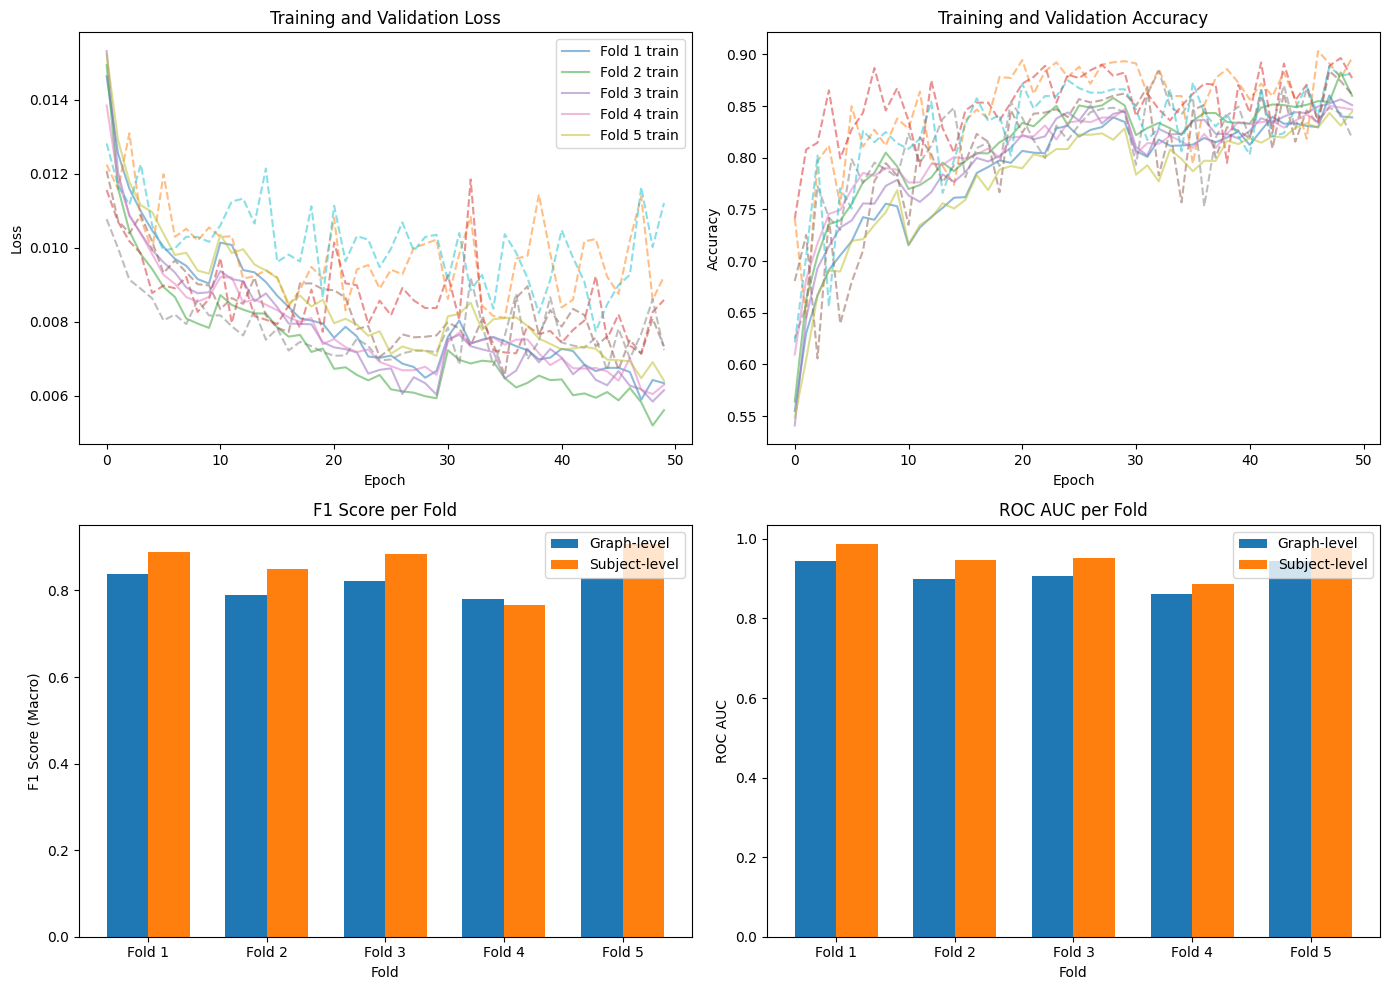

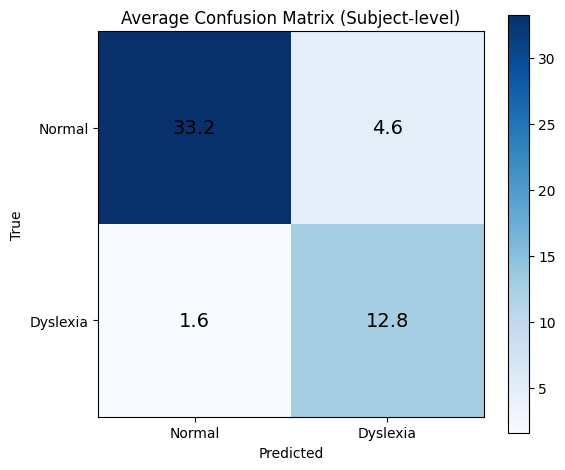

In [ ]:
def plot_results(results):
    """Визуализация результатов обучения"""
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Loss
    ax = axes[0, 0]
    for i, history in enumerate(results['histories']):
        ax.plot(history['train_loss'], alpha=0.5, label=f'Fold {i+1} train')
        ax.plot(history['val_loss'], alpha=0.5, linestyle='--')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Loss')
    ax.legend()

    # Accuracy
    ax = axes[0, 1]
    for i, history in enumerate(results['histories']):
        ax.plot(history['train_acc'], alpha=0.5, label=f'Fold {i+1}')
        ax.plot(history['val_acc'], alpha=0.5, linestyle='--')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training and Validation Accuracy')

    # F1 per fold
    ax = axes[1, 0]
    graph_f1 = [r['f1_macro'] for r in results['graph_results']]
    subject_f1 = [r['f1_macro'] for r in results['subject_results']]
    x = np.arange(len(graph_f1))
    width = 0.35
    ax.bar(x - width/2, graph_f1, width, label='Graph-level')
    ax.bar(x + width/2, subject_f1, width, label='Subject-level')
    ax.set_xlabel('Fold')
    ax.set_ylabel('F1 Score (Macro)')
    ax.set_title('F1 Score per Fold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'Fold {i+1}' for i in range(len(graph_f1))])
    ax.legend()

    # AUC per fold
    ax = axes[1, 1]
    graph_auc = [r.get('roc_auc', 0) for r in results['graph_results']]
    subject_auc = [r['roc_auc'] for r in results['subject_results']]
    ax.bar(x - width/2, graph_auc, width, label='Graph-level')
    ax.bar(x + width/2, subject_auc, width, label='Subject-level')
    ax.set_xlabel('Fold')
    ax.set_ylabel('ROC AUC')
    ax.set_title('ROC AUC per Fold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'Fold {i+1}' for i in range(len(graph_auc))])
    ax.legend()

    plt.tight_layout()
    plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Confusion matrix (усреднённая)
    fig, ax = plt.subplots(figsize=(6, 5))
    avg_cm = np.mean([r['confusion_matrix'] for r in results['subject_results']], axis=0)
    im = ax.imshow(avg_cm, cmap='Blues')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Normal', 'Dyslexia'])
    ax.set_yticklabels(['Normal', 'Dyslexia'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Average Confusion Matrix (Subject-level)')

    for i in range(2):
        for j in range(2):
            ax.text(j, i, f'{avg_cm[i, j]:.1f}', ha='center', va='center', fontsize=14)

    plt.colorbar(im)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()


plot_results(results)